# Phishing Detection Using Machine Learning
---
### Practice Module: Pattern Recognition Systems (PRS)
### Group 18 - Members:
Lim Jun Ming, A0231523U

Mediana, A0231458E

Yeong Wee Ping, A0231533R


#Phishing Dataset Source

[Kaggle Phishing Site](https://www.kaggle.com/taruntiwarihp/phishing-site-urls/download) - url,label

[Kaggle Malicious URL](https://www.kaggle.com/sid321axn/malicious-urls-dataset) - url,label

[OpenPhish](https://OpenPhish.com) - url,label




# Load Packages and File

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip install tldextract -q
# !pip install scikit-plot

In [ ]:
import sys
import os
import scipy
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import scikitplot as skplt

import tldextract
from urllib.parse import urlparse,urlsplit

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import export_graphviz
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from nltk.tokenize import RegexpTokenizer  
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import dataframe_image as dfi

# os.chdir('/content/drive/MyDrive/iss/PRSProjectSharedFolder/')
# print("Current working directory:")
# os.getcwd()
#!dir

In [5]:
# !wget https://openphish.com/feed.txt #500items, feed.txt

In [ ]:
# !mkdir '/content/phishingURL'
# !unzip -q '/content/drive/MyDrive/iss/PRS_Project/phishing_url.zip' -d '/content/phishingURL/'

## Machine Classifier - Phishing

### Load Data and Integrate Multiple Datasets

In [3]:
# pdPhish1 = pd.read_csv("/content/phishingURL/phishing_site_urls.csv")
pdPhish1 = pd.read_csv("phishing_site_urls.csv")
lines = []
with open('phishFeed.txt', encoding = 'utf-8') as f:
    for line in f:
        line=line.strip()
        if line not in lines:
            lines.append((line,'bad'))
f.close()
openPhishData = np.array(lines)
pdOpenPhish = pd.DataFrame(openPhishData, columns=['url', 'label'])
pdOpenPhish.head()
pdPhish1.rename(columns={'URL':'url', 'Label':'label'}, inplace=True)
#Concat
pdPhishing=pd.DataFrame()
pdPhishing= pdPhishing.append([pdPhish1,pdOpenPhish], ignore_index=True)

In [4]:
print("Shape: ", pdPhish1.shape, pdOpenPhish.shape, pdPhishing.shape)
print("Null value:\n", pdPhishing.isnull().sum())
print("Label Counts:\n", pdPhishing.label.value_counts())
print(pdPhishing.describe())
pdPhishing.head()

#Good: 392924, Bad: 251547. No Null

Shape:  (549346, 2) (95125, 2) (644471, 2)
Null value:
 url      0
label    0
dtype: int64
Label Counts:
 good    392924
bad     251547
Name: label, dtype: int64
                                  url   label
count                          644471  644471
unique                         554285       2
top     jhomitevd2abj3fk.tor2web.org/    good
freq                               52  392924


,url,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


### Manual Lexical Features - Data Processing
1. Parse URL (urlparse) into scheme, netloc, path, params, query, fragment
2. Parse URL (tldextract) the domain, subdomain, and suffix
3. Remove corrupted data based on the netloc values
4. Feature Extraction:
URL Length, Hostname/Netloc(netloc_length), path_length, fd_length, suffix_length, num_subdomains{from netloc}, count_dir, path_fs_., domain_, url_, path_, domain-, url-, path-, count@, count?, count%, count., count=, count-https_inpath, count-http_inpath, count-www_inpath, count-digits, count-letters

In [5]:
''' urlparse
Parse a URL into 6 components:
    <scheme>://<netloc>/<path>;<params>?<query>#<fragment>
    Return a 6-tuple: (scheme, netloc, path, params, query, fragment).
'''    
def parse_url(url: str) -> Optional[Dict[str, str]]:
    try:
        no_scheme = not url.startswith('https://') and not url.startswith('http://')
        if no_scheme:
            parsed_url = urlparse(f"http://{url}")
            return {
                "scheme": None, # not established a value for this
                "netloc": parsed_url.netloc,
                "path": parsed_url.path,
                "params": parsed_url.params,
                "query": parsed_url.query,
                "fragment": parsed_url.fragment,
            }
        else:
            parsed_url = urlparse(url)
            return {
                "scheme": parsed_url.scheme,
                "netloc": parsed_url.netloc,
                "path": parsed_url.path,
                "params": parsed_url.params,
                "query": parsed_url.query,
                "fragment": parsed_url.fragment,
            }
    except:
        return None
def tldExtract(url) -> Optional[Dict[str, str]]:
    # extract subdomain, domain, and domain suffix from url
    # if item == '', fill with '<empty>'
    subdomain, domain, domain_suffix = (None if extracted == '' else extracted for extracted in tldextract.extract(url))
    return {"subdomain": subdomain, "domain": domain, "suffix": domain_suffix}

pdPhishing["parsed_url"] = pdPhishing.url.apply(parse_url)
pdPhishing["tldextract"] = pdPhishing.url.apply(tldExtract)

pdPhishing = pd.concat([pdPhishing.drop(['parsed_url'], axis=1), pdPhishing['parsed_url'].apply(pd.Series)], axis=1)
pdPhishing = pd.concat([pdPhishing.drop(['tldextract'], axis=1), pdPhishing['tldextract'].apply(pd.Series)], axis=1)
pdPhishing.head()

,url,label,scheme,netloc,path,params,query,fragment,subdomain,domain,suffix
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,None,nobell.it,/70ffb52d079109dca5664cce6f317373782/login.Sky...,,cmd=_profile-ach&outdated_page_tmpl=p/gen/fail...,,None,nobell,it
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,None,www.dghjdgf.com,/paypal.co.uk/cycgi-bin/webscrcmd=_home-custom...,,,,www,dghjdgf,com
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,None,serviciosbys.com,/paypal.cgi.bin.get-into.herf.secure.dispatch3...,,,,None,serviciosbys,com
3,mail.printakid.com/www.online.americanexpress....,bad,None,mail.printakid.com,/www.online.americanexpress.com/index.html,,,,mail,printakid,com
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,None,thewhiskeydregs.com,/wp-content/themes/widescreen/includes/temp/pr...,,84784787824HDJNDJDSJSHD//2724782784/,,None,thewhiskeydregs,com


In [6]:
#Remove Corrupted Data
print(pdPhishing.netloc.isnull().sum())
for idx, i in enumerate(pdPhishing.netloc.values):
    if type(i) is not str:
        print(idx, pdPhishing.url.values[idx],pdPhishing.label.values[idx])
pdPhishing.shape
#remove null_netloc
pdPhishing=pdPhishing[~pdPhishing.netloc.isnull()].reset_index()
pdPhishing=pdPhishing.drop("index", axis=1)
print(pdPhishing.shape)

30
18245 RybjUxÙãl5»7ÆE%ÝÔk+h|U+ýk©ìÉ½Æq]âF·õÁ¢w)ëA·ç°{t*m!¦2 good
18277 ÆeF§÷%¶¿Õ½9¿b@Ö¸ÚZE¤ÒC¢ÄÅª2åç-]W³fU¤Jgkz.ø¿nJçåæuøD%@ðûÇùM¹uË good
18278 Ó6¸RTÃu~æÙg0>÷mÖiÓ=;XZ\%êýÜÉfn&\°%7õÉ"ieÖ1ÄÁêFÐò<$cï6t[0ò2"/Æa^2âpù/ýãÇ$E¬R«È²ú[Ì¶p¥qÒ°i°^ò[»³»]±9êdÓS¿Ë]ùþ5j¿·ªocÂplà7ÊÏJ§¢#3ðDCDõ²çÇGÝ.Vò=¿QB§Ä'`ÊáZÉê ÔîÆm®ÍÝQÓ(z;¹Áê¬âytÖÙ®ëNP²ÜEQ good
18283 µÔA¨!ÝÛ=]º£¦Pôwr72-ÕY5Äòè7¬-³]×)&¡e¸¢À6RD­NvY¨Ð«Ñ3Â¸%Qñ+ÛÈ¸$¶gz{þ good
18288 ¨RÊÃûaCóÞit×ßÂe-DÖØ+9YèÌçÏ¯·"0£ÙÕ.0ößF«7¹NRÙ{ccÉÄãéçx[Ä6a5Ñ³LÖíÜÉÀ£Òma¥yRX*0ÅÝ7×ÊÁÌo«Õs¶0kdèÑ&Ä"Ï¨mZ'àDM×ñXÚÒK"päî±h¬cAÊeK@4r"^'ÓFþ1*ËË PÞô;õ$úàÑ@þ=êWÑ"Ãhñ®ç^«Ýó^çRúUJ.<6CyÜFØrÿV2ôæýZãiiIb;¨Ëµu^ÍVy)­è»âýº+SÖáÃì?å6åÔ/ good
18296 1]Î¼0#W»æ½Î4>¥õª(\xl3(ò5?¹(°åþ¬eéÍûµÆÒÒ-&Äv&-Q/9jê½2­ òS;[ÑwÅûtW?(§3¬</Â!*Ø~?ÊmË¨^XV¹µÂ¦3¨|[÷4fÈë<	ô·»n³HéÜúÂÒá/Wîà.K3q4:å)¿®IK.°x±&R6¹àÄ#|9³¢Üùñ~3 good
1

In [7]:
# #First Directory Length
def fd_length(url_path):
    try:
        return len(url_path.split('/')[1])
    except:
        return 0

def get_num_subdomains(netloc: str) -> int:
    subdomain = tldextract.extract(netloc).subdomain 
    if subdomain == "":
        return 0
    return subdomain.count('.') + 1

pdPhishing['num_subdomains'] = pdPhishing['netloc'].apply(lambda i: get_num_subdomains(i))

def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
    
#URL Length, Hostname Length, PathLength
pdPhishing['tot_url_length'] = pdPhishing['url'].apply(lambda i: len((i)))
pdPhishing['netloc_length'] =  pdPhishing['netloc'].apply(lambda i: len((i)))
pdPhishing['path_length'] = pdPhishing['path'].apply(lambda i: len((i)))

pdPhishing['fd_length'] = pdPhishing['path'].apply(lambda i: fd_length(i))
pdPhishing['suffix_length'] = pdPhishing['suffix'].apply(lambda i: len(str(i)))

#CountFeatures

pdPhishing['count_dir'] = pdPhishing['path'].str.count('/')
pdPhishing['path_fsdot'] = pdPhishing['path'].apply(lambda i: i.count('.')) #malicious.com/paypal.com

pdPhishing['domain_'] = pdPhishing['netloc'].apply(lambda i: i.count('_'))
pdPhishing['countunderscore'] = pdPhishing['url'].apply(lambda i: i.count('_'))
pdPhishing['path_'] = pdPhishing['path'].apply(lambda i: i.count('_'))

pdPhishing['domaindesk'] = pdPhishing['netloc'].apply(lambda i: i.count('-'))
pdPhishing['urldesk'] = pdPhishing['url'].apply(lambda i: i.count('-'))
pdPhishing['pathdesk'] = pdPhishing['path'].apply(lambda i: i.count('-'))


pdPhishing['countat'] = pdPhishing['url'].apply(lambda i: i.count('@'))
pdPhishing['countquest'] = pdPhishing['url'].apply(lambda i: i.count('?'))
pdPhishing['countpercent'] = pdPhishing['url'].apply(lambda i: i.count('%'))
pdPhishing['countdot'] = pdPhishing['url'].apply(lambda i: i.count('.'))
pdPhishing['counteq'] = pdPhishing['url'].apply(lambda i: i.count('='))

pdPhishing['count_http_inpath'] = pdPhishing['path'].apply(lambda i : i.count('http'))
pdPhishing['count_https_inpath'] = pdPhishing['path'].apply(lambda i : i.count('https'))
pdPhishing['count_www_inpath'] = pdPhishing['path'].apply(lambda i: i.count('www'))

pdPhishing['countdigits']= pdPhishing['url'].apply(lambda i: digit_count(i))
pdPhishing['countletters']= pdPhishing['url'].apply(lambda i: letter_count(i))

In [ ]:
colList=pdPhishing.columns
for i in colList:
    print(i, " - Null: ", pdPhishing[str(i)].isnull().sum())
display(pdPhishing.head())

### CountVectorizer and TFIDF - Tokenize & Stem

In [9]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
pdPhishing['url_tokenized'] = pdPhishing.url.map(lambda t: tokenizer.tokenize(t))
#SnowballStemmer
#Snowball is a small string processing language, gives root words. More aggressive than porter
root_words = SnowballStemmer("english")
pdPhishing['root_words'] = pdPhishing['url_tokenized'].map(lambda l: [root_words.stem(word) for word in l])
#take all rootwords into sentences to be pass to CountVectorizer
pdPhishing['url_sentence'] = pdPhishing['root_words'].map(lambda l: ' '.join(l))
pdPhishing.head()

,url,label,scheme,netloc,path,params,query,fragment,subdomain,domain,...,countdot,counteq,count_http_inpath,count_https_inpath,count_www_inpath,countdigits,countletters,url_tokenized,root_words,url_sentence
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,None,nobell.it,/70ffb52d079109dca5664cce6f317373782/login.Sky...,,cmd=_profile-ach&outdated_page_tmpl=p/gen/fail...,,None,nobell,...,6,4,0,0,0,58,135,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,None,www.dghjdgf.com,/paypal.co.uk/cycgi-bin/webscrcmd=_home-custom...,,,,www,dghjdgf,...,5,2,0,0,0,1,65,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,None,serviciosbys.com,/paypal.cgi.bin.get-into.herf.secure.dispatch3...,,,,None,serviciosbys,...,7,0,0,0,0,47,111,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,None,mail.printakid.com,/www.online.americanexpress.com/index.html,,,,mail,printakid,...,6,0,0,0,1,0,52,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,None,thewhiskeydregs.com,/wp-content/themes/widescreen/includes/temp/pr...,,84784787824HDJNDJDSJSHD//2724782784/,,None,thewhiskeydregs,...,1,0,0,0,0,21,82,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


###Split Training/Testing Dataset, Scaling (Manual FExt)

In [10]:
x = pdPhishing[['tot_url_length',
       'netloc_length', 'path_length', 'fd_length', 'suffix_length',
       'num_subdomains', 'domaindesk', 'urldesk', 'pathdesk', 'domain_', 'countunderscore',
       'path_', 'count_dir', 'path_fsdot', 'countat', 'countquest', 'countpercent',
       'countdot', 'counteq', 'count_http_inpath', 'count_https_inpath',
       'count_www_inpath', 'countdigits', 'countletters']]

le = LabelEncoder()
y=le.fit_transform(pdPhishing.label) #bad=0, good=1
# le.inverse_transform([0])

#Splitting the data into Training, Validation, Test - 0.7, 0.15, 0.15 ratio
x_train, x_valtest, y_train, y_valtest = train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size=0.5, stratify=y_valtest, random_state=42)
scaler = StandardScaler()  
scaler.fit(x_train)

x_train_scale = scaler.transform(x_train)
x_val_scale = scaler.transform(x_val)
x_test_scale = scaler.transform(x_test)  

###Split Training/Testing Dataset - CountVectorizer and TFIDFVectorizer

In [11]:
x_train_tkn, x_valtest_tkn, y_train_tkn, y_valtest_tkn = train_test_split(pdPhishing.url_sentence, y, test_size=0.3, stratify=y, random_state=42)
x_val_tkn, x_test_tkn, y_val_tkn, y_test_tkn = train_test_split(x_valtest_tkn, y_valtest_tkn, test_size=0.5, stratify=y_valtest_tkn, random_state=42)

y_train_cv, y_train_tf = y_train_tkn, y_train_tkn
y_val_cv, y_val_tf = y_val_tkn, y_val_tkn
y_test_cv, y_test_tf = y_test_tkn, y_test_tkn


cv = CountVectorizer()
tfidf_v =TfidfVectorizer()

cv_f= cv.fit(x_train_tkn)
tfidf_f= tfidf_v.fit(x_train_tkn)

x_train_cv = cv.transform(x_train_tkn)
x_val_cv = cv.transform(x_val_tkn)
x_test_cv = cv.transform(x_test_tkn)  

x_train_tf = tfidf_v.transform(x_train_tkn)
x_val_tf = tfidf_v.transform(x_val_tkn)
x_test_tf = tfidf_v.transform(x_test_tkn)  

# Data Visualisation

In [12]:
#split data into two
bad_sites = pdPhishing[pdPhishing.label == 'bad']
good_sites = pdPhishing[pdPhishing.label == 'good']

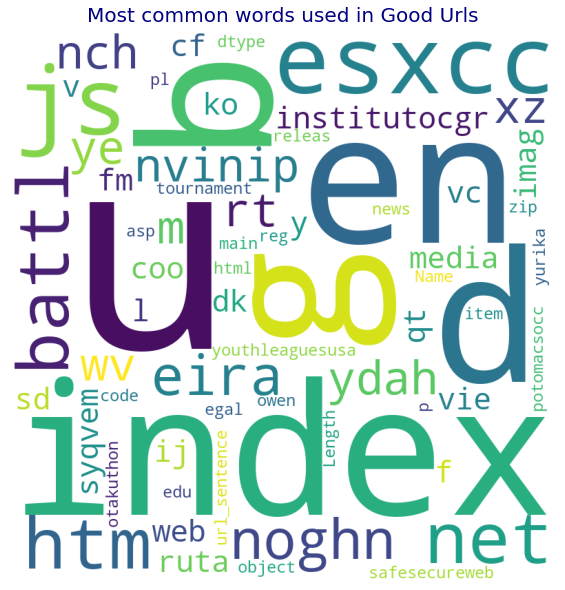

In [13]:
## WorldCloud for Good URLS

data = good_sites.url_sentence
data.reset_index(drop=True, inplace=True)
text = str(data)

stopwords = set(STOPWORDS).union({'com','http','www'})  
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, max_words = 400, min_font_size = 10).generate(text)
  
               
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.title("Most common words used in Good Urls", fontdict={'size': 20, 'color': 'navy', 'verticalalignment': 'bottom'})
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

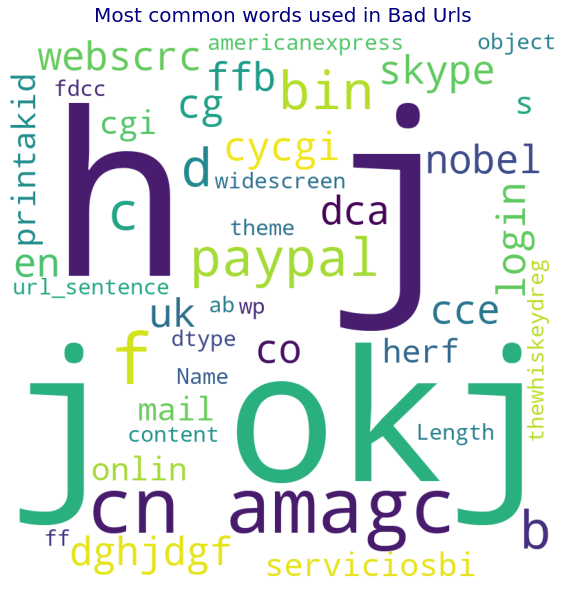

In [14]:
#worldcloud for bad url

data = bad_sites.url_sentence
data.reset_index(drop=True, inplace=True)
text = str(data)


stopwords = set(STOPWORDS).union({'com','http','www'})  
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, max_words = 400, min_font_size = 10).generate(text)
  
               
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.title("Most common words used in Bad Urls", fontdict={'size': 20, 'color': 'navy', 'verticalalignment': 'bottom'})
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

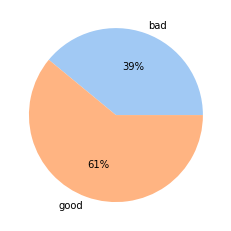

In [72]:
#define data
data = [len(pdPhishing[pdPhishing['label']=='bad']), len(pdPhishing[pdPhishing['label']=='good'])]
labels = pdPhishing['label'].unique()

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

Percent Of Malicious URLs:39.03 %
Percent Of Benign URLs:60.97 %


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\si

(0.0, 10000.0)

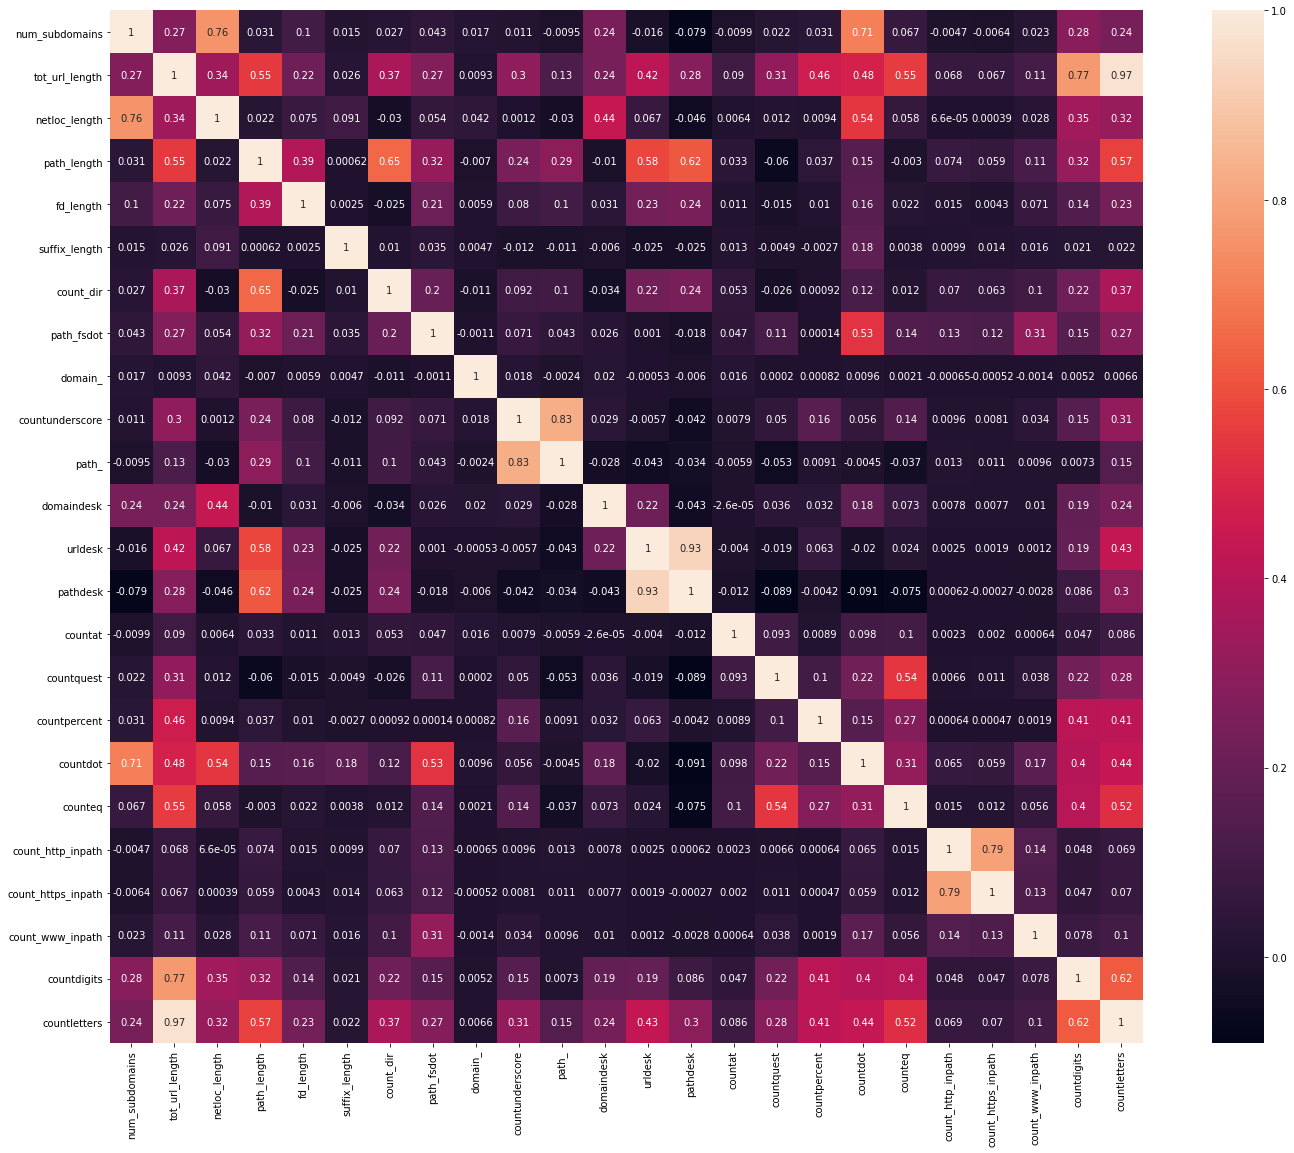

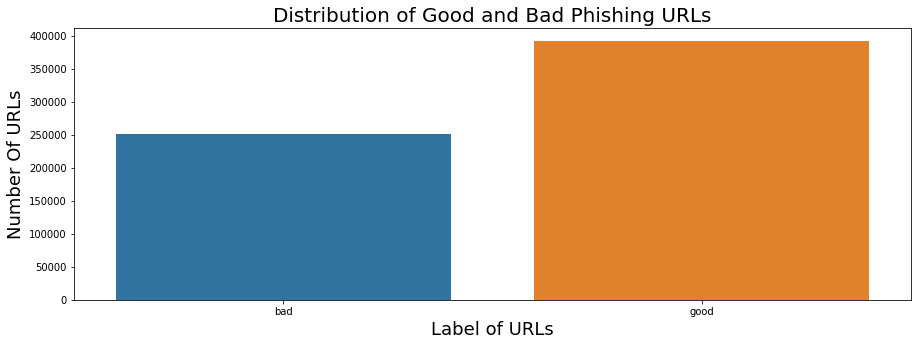

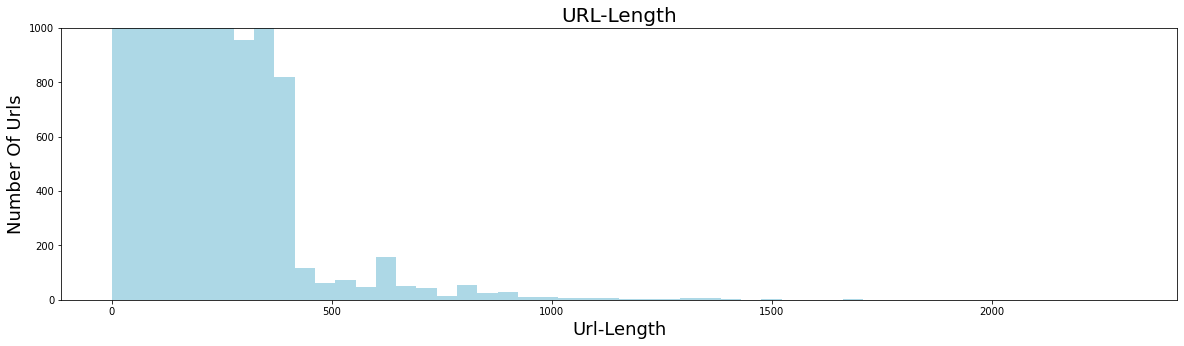

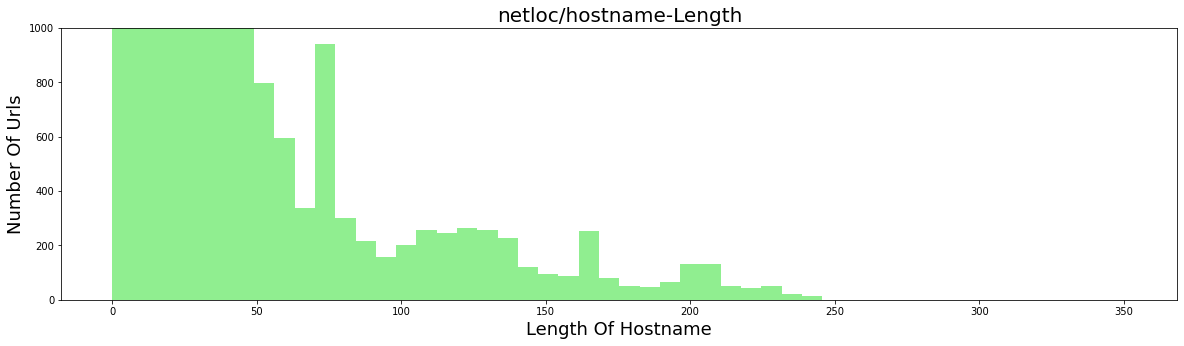

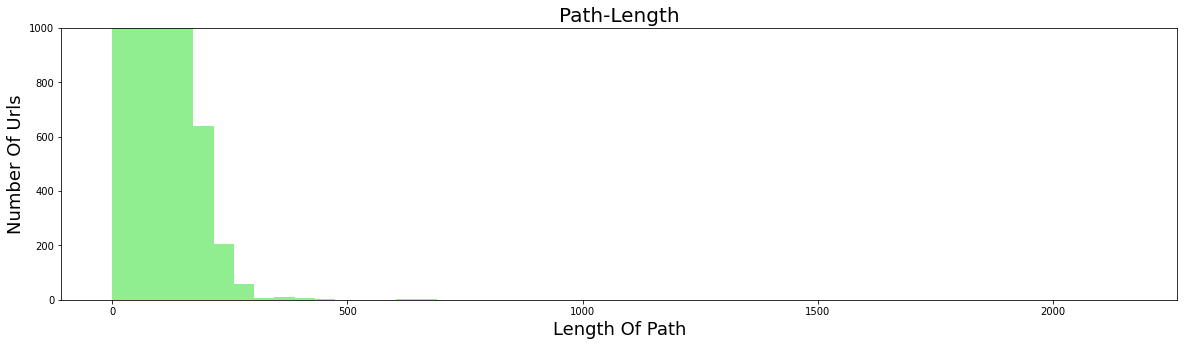

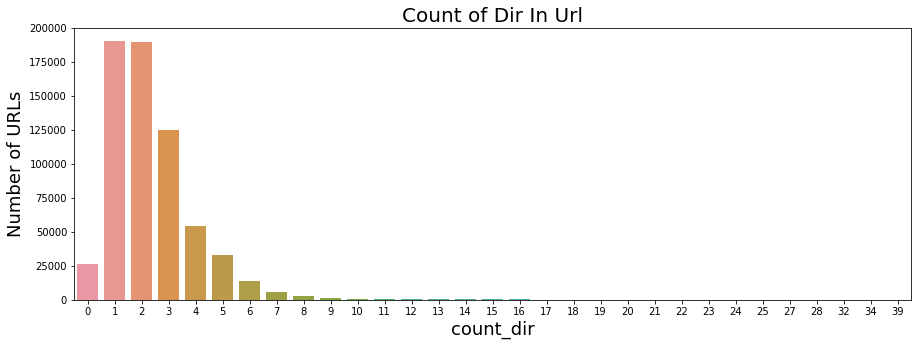

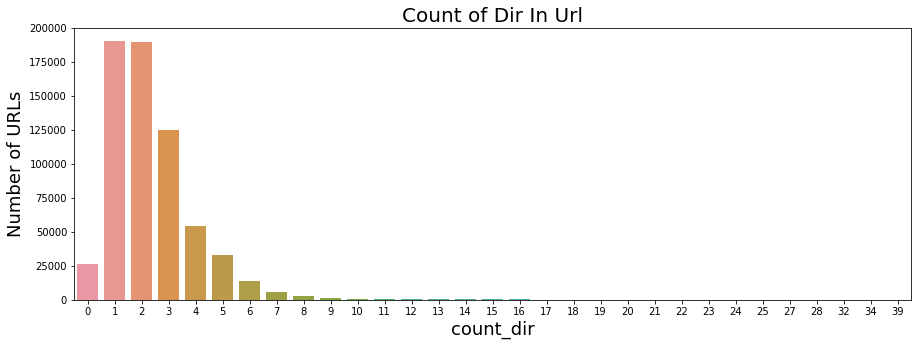

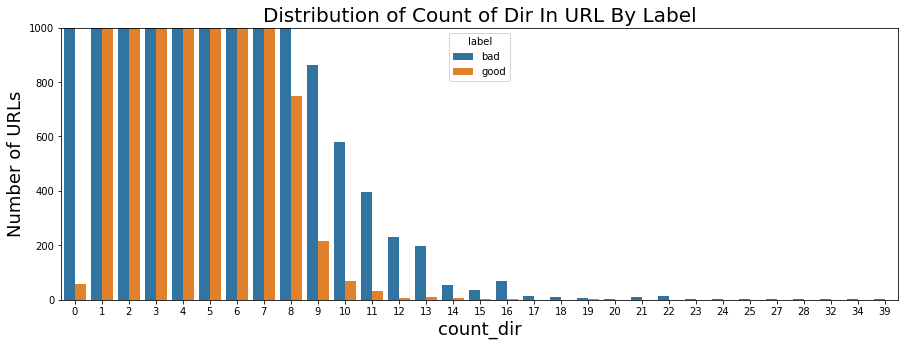

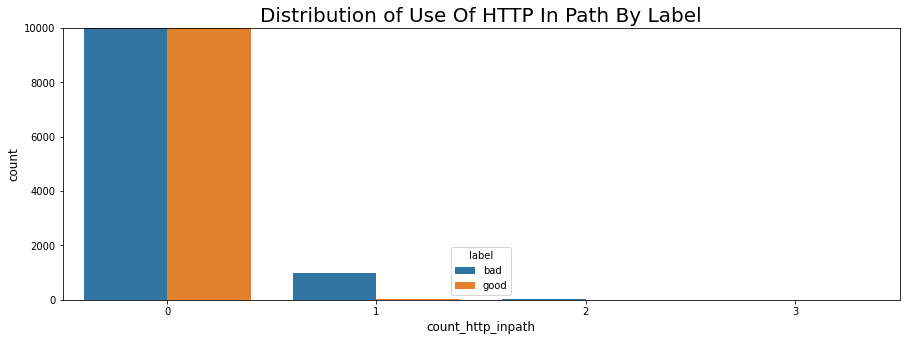

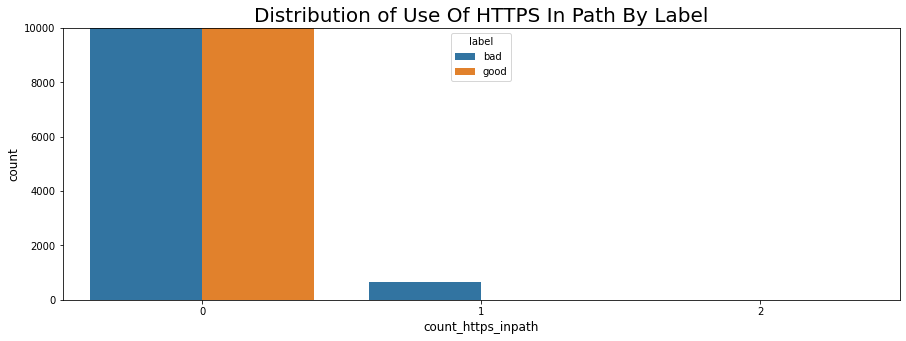

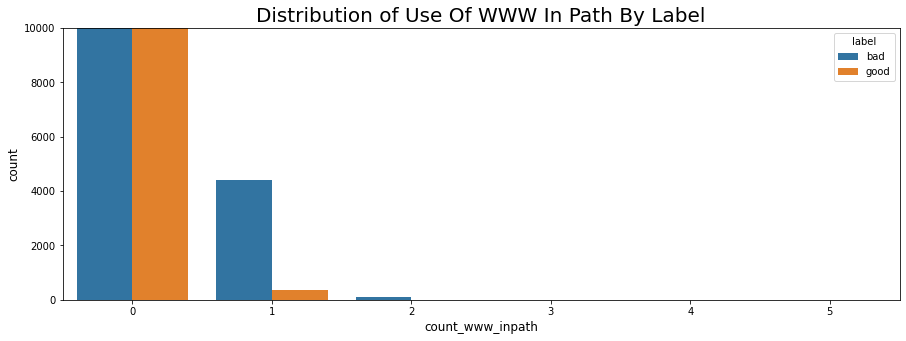

In [61]:
#Heatmap
corrmat = pdPhishing.corr()
f, ax = plt.subplots(figsize=(25,19))
sns.heatmap(corrmat, square=True, annot = True, annot_kws={'size':10})

plt.figure(figsize=(15,5))
sns.countplot(x='label',data=pdPhishing)
plt.title("Distribution of Good and Bad Phishing URLs",fontsize=20)
plt.xlabel("Label of URLs",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

print("Percent Of Malicious URLs:{:.2f} %".format(len(pdPhishing[pdPhishing['label']=='bad'])/len(pdPhishing['label'])*100))
print("Percent Of Benign URLs:{:.2f} %".format(len(pdPhishing[pdPhishing['label']=='good'])/len(pdPhishing['label'])*100))

#class imbalance to some extent
plt.figure(figsize=(20,5))
plt.hist(pdPhishing['tot_url_length'],bins=50,color='LightBlue')
plt.title("URL-Length",fontsize=20)
plt.xlabel("Url-Length",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)
plt.ylim(0,1000)

plt.figure(figsize=(20,5))
plt.hist(pdPhishing['netloc_length'],bins=50,color='Lightgreen')
plt.title("netloc/hostname-Length",fontsize=20)
plt.xlabel("Length Of Hostname",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)
plt.ylim(0,1000)

plt.figure(figsize=(20,5))
plt.hist(pdPhishing['path_length'],bins=50,color='Lightgreen')
plt.title("Path-Length",fontsize=20)
plt.xlabel("Length Of Path",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)
plt.ylim(0,1000)

plt.figure(figsize=(15,5))
plt.title("Count of Dir In Url",fontsize=20)
plt.xlabel("Count of Dir",fontsize=18)
sns.countplot(pdPhishing['count_dir'])
plt.ylabel("Number of URLs",fontsize=18)

plt.figure(figsize=(15,5))
plt.title("Count of Dir In Url",fontsize=20)
plt.xlabel("Count of Dir",fontsize=18)
sns.countplot(pdPhishing['count_dir'])
plt.ylabel("Number of URLs",fontsize=18)

plt.figure(figsize=(15,5))
plt.title("Distribution of Count of Dir In URL By Label",fontsize=20)
plt.xlabel("Count Of Dir",fontsize=18)
plt.ylabel("Number of URLs",fontsize=18)
plt.ylim((0,1000))
sns.countplot(pdPhishing['count_dir'],hue='label',data=pdPhishing)
plt.ylabel("Number of URLs",fontsize=18)

plt.figure(figsize=(15,5))
plt.title("Distribution of Use Of HTTP In Path By Label",fontsize=20)
plt.xlabel("Count Of http",fontsize=12)
plt.ylabel("Number of URLs",fontsize=12)
plt.ylim((0,10000))
sns.countplot(pdPhishing['count_http_inpath'],hue='label',data=pdPhishing)

plt.figure(figsize=(15,5))
plt.title("Distribution of Use Of HTTPS In Path By Label",fontsize=20)
plt.xlabel("Count Of https",fontsize=12)
plt.ylabel("Number of URLs",fontsize=12)
plt.ylim((0,10000))
sns.countplot(pdPhishing['count_https_inpath'],hue='label',data=pdPhishing)

plt.figure(figsize=(15,5))
plt.title("Distribution of Use Of WWW In Path By Label",fontsize=20)
plt.xlabel("Count Of WWW",fontsize=12)
plt.ylabel("Number Of URLs",fontsize=12)
sns.countplot(pdPhishing['count_www_inpath'],hue='label',data=pdPhishing)
plt.ylim(0,10000)



# Function Definition - 

## Plotting, Performance, Saving Result

In [116]:
def perfResult(x_train, x_test, y_train, y_test, model):
    model.fit(x_train, y_train)
    tr_predict = model.predict(x_train)
    ts_predict = model.predict(x_test)
    tr_accuracy = accuracy_score(y_train, tr_predict)
    ts_accuracy = accuracy_score(y_test, ts_predict)
    modelName = str(model).split("(")[0]
    print(modelName)
    print(f"Train Accuracy Score: {tr_accuracy}")
    print(f"Test Accuracy Score: {ts_accuracy}\n")
    print(confusion_matrix(y_test,ts_predict))
    print(classification_report(y_test,ts_predict))
    saveModel(model, modelName)
    return [tr_predict, ts_predict, tr_accuracy, ts_accuracy]

#plotting ROC Chart
def plotROC_CummGain_Lift(x_train, x_test, y_train, y_test, model):
    y_pred_prob = model.predict_proba(x_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:,1])
    auc = roc_auc_score(y_test, y_pred_prob[:,1])
    modelName = str(model).split("(")[0]
    plt.title(modelName + " ROC")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label=modelName+ ", auc="+str(auc)[:5])
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc=4)
    plt.show()
    skplt.metrics.plot_cumulative_gain(y_test, y_pred_prob)
    plt.show()
    skplt.metrics.plot_lift_curve(y_test, y_pred_prob)
    plt.show()
    
#plotting ROC Chart
def plotROC(x_train, x_test, y_train, y_test, model):
    y_pred_prob = model.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
    auc = roc_auc_score(y_test, y_pred_prob[:,1])
    modelName = str(model).split("(")[0]
    plt.title(modelName + " ROC")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label=modelName+ ", roc_auc="+str(auc)[:5])
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc=4)
    plt.show()
    return (y_pred_prob, fpr, tpr, auc)

#import GridSearchCV
from sklearn.model_selection import GridSearchCV
def gridSearchCV(x_train, x_test, y_train, y_test, model, param, cv_value):
    model_cv=GridSearchCV(model, param, cv=cv_value)
    model_cv.fit(x_train, y_train)
    # print('TrainScore: ', model_cv.score(x_train, y_train))
    # print('TestScore: ', model_cv.score(x_test, y_test))
    best_score = model_cv.best_score_
    best_params = model_cv.best_params_
    print("Best Score:" + str(best_score))
    print("Best Parameters: " + str(best_params))
    return (best_score, best_params)

###SaveModelFunction

In [160]:
import pickle
def saveModel(model, modelname):
    pathfolder="model/"
    pickle.dump(model, open(pathfolder+modelname+".pkl", 'wb'))

##SAVING

In [75]:
# saveModel(scaler, "vectorizer/scaler")
# saveModel(cv, 'vectorizer/cv2')
# saveModel(tfidf_v, 'vectorizer/tfidf_v2')

# with open('/content/drive/MyDrive/iss/PRS_Project/vectorizer/tfidf_v2.pkl', 'rb') as f:
#     tfidf_v = pickle.load(f)
# f.close()

# with open('/content/drive/MyDrive/iss/PRS_Project/vectorizer/cv2.pkl', 'rb') as f:
#     cv = pickle.load(f)
# f.close()
# cvFeatures=cv.transform(pdPhishing.url_sentence)
# tfidfFeatures = tfidf_v.transform(pdPhishing.url_sentence)
# print('The length of vocabulary', len(tfidf_v.get_feature_names()))

### Save Cleanup CSV


In [ ]:
# compression_opts = dict(method='zip', archive_name='pdPhishing.csv')
# pdPhishing.to_csv("/content/drive/MyDrive/iss/PRS_Project/pdPhishing_oct.zip",index=False,compression=compression_opts)

### Load CleanCSV

In [ ]:
# !mkdir '/content/phishingURL'
# !unzip -q '/content/drive/MyDrive/iss/PRS_Project/pdPhishing_oct.zip' -d '/content/phishingURL/'
# pdPhishing = pd.read_csv('/content/phishingURL/pdPhishing.csv')
# pdPhishing.head()
# print("Shape: ", pdPhishing.shape)
# print("Null value:\n", pdPhishing.isnull().sum())
# print("Label Counts:\n", pdPhishing.label.value_counts())
# print(pdPhishing.describe())
# pdPhishing.head()

# Build Model (Manual vs CountVect vs TFIDF)

```
Models for comparison
1. KNN
2. Logistic Regression
3. Decision Trees
4. Random Forest
5. AdaBoost
6. NB
7. MLP*
```



####Init|

In [19]:
# Initialization
X_labels = ['Manual', 'CountVect', 'TfIdf'] # List of Descriptions of X feature map
X_train = [x_train_scale, x_train_cv, x_train_tf] # List of X feature map for training
X_val = [x_val_scale, x_val_cv, x_val_tf] # List of X feature map for validation
X_test = [x_test_scale, x_test_cv, x_test_tf] # List of X feature map for testing

#### Logistic Regression

##### Training

In [78]:

# Parameters Setup
metrics = ['Input Feature Types', 'Regularization Strength', 'Training Accuracy', 'Validation Accuracy', 'F1-Score', 'AUC Score']
reg_str = [3, 2, 1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001] # different regularization strength to try out
modelname = 'LogisticRegresion'

# Initialize
labels = []
reg = []
tr_acc = []
tv_acc = []
F1 = []
auc = []
fpr = []
tpr = []

for i in range(len(X_labels)):
  for r in reg_str:
    labels.append(X_labels[i])
    reg.append(r)

    lr = LogisticRegression(C=r)
    lr_fit = lr.fit(X_train[i], y_train)

    # Predictions
    lr_trpred = lr.predict(X_train[i])
    lr_tvpred = lr.predict(X_val[i])
    lr_tvprob = lr.predict_proba(X_val[i])

    # Accuracies  
    tr_acc.append(accuracy_score(y_train, lr_trpred))
    tv_acc.append(accuracy_score(y_val, lr_tvpred))
    
    # F1 Score
    F1.append(f1_score(y_val, lr_tvpred))

    # AUC Score
    auc.append(roc_auc_score(y_val, lr_tvprob[:,1]))

# Training Evaluation Results
lr_val_sumarr = np.array([labels, reg, tr_acc, tv_acc, F1, auc]).transpose()
lr_val_sum = pd.DataFrame(lr_val_sumarr, columns=metrics)
for i in metrics[2:]:
  lr_val_sum[i] = lr_val_sum[i].apply(lambda x: round(float(x),3))

# Save Training Evaluation Results
folderpath = 'model/trad_model/hyperparameter_tuning/'
filepath = folderpath + modelname + '.csv'
lr_val_sum.to_csv(filepath, index=False)

display(lr_val_sum)


,Input Feature Types,Regularization Strength,Training Accuracy,Validation Accuracy,F1-Score,AUC Score
0,Manual,3.000,0.723,0.719,0.793,0.792
1,Manual,2.000,0.723,0.719,0.793,0.792
2,Manual,1.000,0.723,0.719,0.793,0.791
3,Manual,0.300,0.723,0.719,0.793,0.791
4,Manual,0.100,0.722,0.719,0.793,0.791
5,Manual,0.030,0.720,0.717,0.791,0.789
6,Manual,0.010,0.717,0.715,0.790,0.788
7,Manual,0.003,0.713,0.710,0.787,0.785
8,Manual,0.001,0.710,0.708,0.786,0.782
9,CountVect,3.000,0.910,0.868,0.895,0.956


#####Tuning

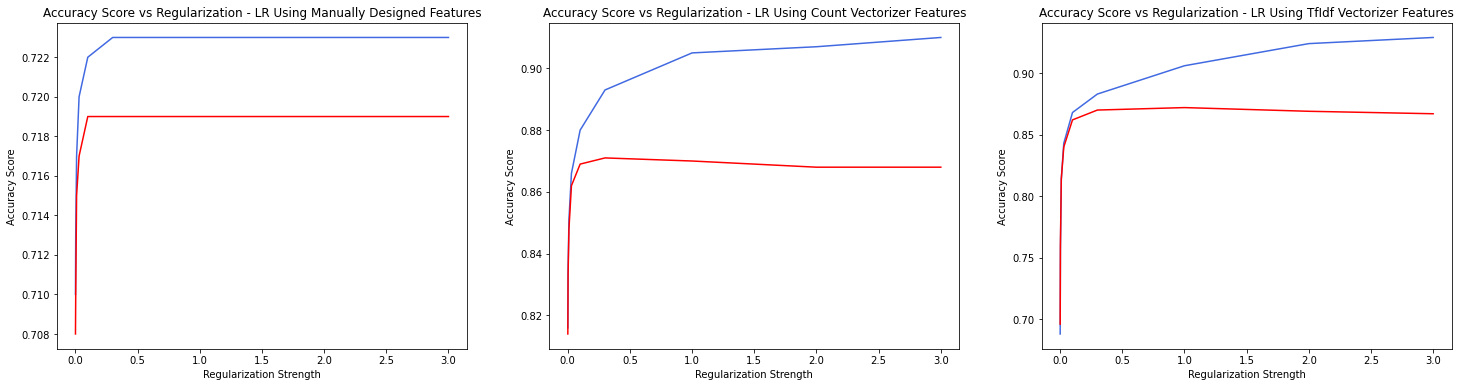

In [103]:
# Initialize Plot
plt.figure(figsize=(25,6))

# Plot Accuracies vs Regularization Strength for Logistic Regression using manually designed features
plt.subplot(131)
mfd_train_acc = lr_val_sum['Training Accuracy'][lr_val_sum['Input Feature Types'] == 'Manual']
mfd_test_acc = lr_val_sum['Validation Accuracy'][lr_val_sum['Input Feature Types'] == 'Manual']
plt.plot(reg_str, mfd_train_acc, color='royalblue')
plt.plot(reg_str, mfd_test_acc, color='red')
plt.xlabel('Regularization Strength')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs Regularization - LR Using Manually Designed Features')

# Plot Accuracies vs Regularization Strength for Logistic Regression using CountVectorizer features map
plt.subplot(132)
cv_train_acc = lr_val_sum['Training Accuracy'][lr_val_sum['Input Feature Types'] == 'CountVect']
cv_test_acc = lr_val_sum['Validation Accuracy'][lr_val_sum['Input Feature Types'] == 'CountVect']
plt.plot(reg_str, cv_train_acc, color='royalblue')
plt.plot(reg_str, cv_test_acc, color='red')
plt.xlabel('Regularization Strength')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs Regularization - LR Using Count Vectorizer Features')

# Plot Accuracies vs Regularization Strength for Logistic Regression using Tfidf features map
plt.subplot(133)
tfidf_train_acc = lr_val_sum['Training Accuracy'][lr_val_sum['Input Feature Types'] == 'TfIdf']
tfidf_test_acc = lr_val_sum['Validation Accuracy'][lr_val_sum['Input Feature Types'] == 'TfIdf']
plt.plot(reg_str, tfidf_train_acc, color='royalblue')
plt.plot(reg_str, tfidf_test_acc, color='red')
plt.xlabel('Regularization Strength')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs Regularization - LR Using TfIdf Vectorizer Features')

plt.show()


#####Evaluate

In [111]:
# Parameters Setup
metrics = ['Input Feature Types', 'Regularization Strength', 'Training Accuracy', 'Testing Accuracy', 'F1-Score', 'AUC Score']
modelname = 'LogisticRegresion'
colors = ['blue', 'orange', 'red'] # indicates the corresponding color to represent in plot results

# Using C=0.1 for LR in Manually Designed Features
lr_mfd = LogisticRegression(C=0.1)
lr_mfd_fit = lr_mfd.fit(X_train[0], y_train)
lr_mfd_trpred = lr_mfd.predict(X_train[0])
lr_mfd_tspred = lr_mfd.predict(X_test[0])
lr_mfd_tsprob = lr_mfd.predict_proba(X_test[0])
lr_mfd_tracc = accuracy_score(y_train, lr_mfd_trpred)
lr_mfd_tsacc = accuracy_score(y_test, lr_mfd_tspred)
lr_mfd_f1 = f1_score(y_test, lr_mfd_tspred)
lr_mfd_auc = roc_auc_score(y_test, lr_mfd_tsprob[:,1])
lr_mfd_fpr, lr_mfd_tpr, _ = roc_curve(y_test, lr_mfd_tsprob[:,1])

# Using C=0.3 for LR in CountVectorizer Features
lr_cv = LogisticRegression(C=0.3)
lr_cv_fit = lr_cv.fit(x_train_cv, y_train_tkn)
lr_cv_trpred = lr_cv.predict(x_train_cv)
lr_cv_tspred = lr_cv.predict(x_test_cv)
lr_cv_tsprob = lr_cv.predict_proba(x_test_cv)
lr_cv_tracc = accuracy_score(y_train_tkn, lr_cv_trpred)
lr_cv_tsacc = accuracy_score(y_test_tkn, lr_cv_tspred)
lr_cv_f1 = f1_score(y_test_tkn, lr_cv_tspred)
lr_cv_auc = roc_auc_score(y_test_tkn, lr_cv_tsprob[:,1])
lr_cv_fpr, lr_cv_tpr, _ = roc_curve(y_test_tkn, lr_cv_tsprob[:,1])

# Using C=1 for LR in TfIdf Vectorizer Features
lr_tfidf = LogisticRegression(C=1)
lr_tfidf_fit = lr_tfidf.fit(x_train_tf, y_train_tkn)
lr_tfidf_trpred = lr_tfidf.predict(x_train_tf)
lr_tfidf_tspred = lr_tfidf.predict(x_test_tf)
lr_tfidf_tsprob = lr_tfidf.predict_proba(x_test_tf)
lr_tfidf_tracc = accuracy_score(y_train_tkn, lr_tfidf_trpred)
lr_tfidf_tsacc = accuracy_score(y_test_tkn, lr_tfidf_tspred)
lr_tfidf_f1 = f1_score(y_test_tkn, lr_tfidf_tspred)
lr_tfidf_auc = roc_auc_score(y_test_tkn, lr_tfidf_tsprob[:,1])
lr_tfidf_fpr, lr_tfidf_tpr, _ = roc_curve(y_test_tkn, lr_tfidf_tsprob[:,1])

lr_tracc = [lr_mfd_tracc, lr_cv_tracc, lr_tfidf_tracc]
lr_tsacc = [lr_mfd_tsacc, lr_cv_tsacc, lr_tfidf_tsacc]
lr_f1 = [lr_mfd_f1, lr_cv_f1, lr_tfidf_f1]
lr_auc = [lr_mfd_auc, lr_cv_auc, lr_tfidf_auc]
lr_c = [0.1, 0.3, 1]
lr_labels = ['Manual', 'CountVect', 'TfIdf']
lr_fpr = [lr_mfd_fpr, lr_cv_fpr, lr_tfidf_fpr]
lr_tpr = [lr_mfd_tpr, lr_cv_tpr, lr_tfidf_tpr]

# Displaying final model evaluation
lr_sumarr = np.array([lr_labels, lr_c, lr_tracc, lr_tsacc, lr_f1, lr_auc]).transpose()
lr_sum = pd.DataFrame(lr_sumarr, columns=metrics)
for i in metrics[2:]:
  lr_sum[i] = lr_sum[i].apply(lambda x: round(float(x),3))

# Save Test Dataset Evaluation to File
folderpath = 'model/trad_model/model_evaluation/'
filepath = folderpath + modelname + '.csv'
lr_sum.to_csv(filepath, index=False)
display(lr_sum)

,Input Feature Types,Regularization Strength,Training Accuracy,Testing Accuracy,F1-Score,AUC Score
0,Manual,0.1,0.722,0.721,0.794,0.794
1,CountVect,0.3,0.893,0.872,0.898,0.958
2,TfIdf,1,0.906,0.873,0.899,0.936


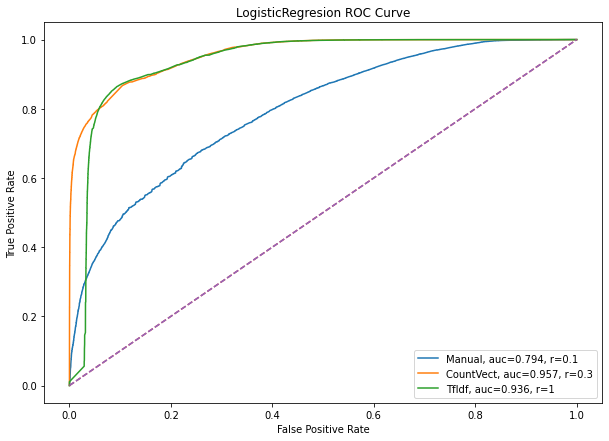

In [ ]:
display(lr_sum)

# Plot of ROC Curve
plt.figure(figsize=(10,7))
for i in np.arange(len(X_labels)):
  plt.plot(lr_fpr[i],lr_tpr[i], label=lr_labels[i]+  ", auc="+str(lr_auc[i])[:5] + ", r=" + str(lr_c[i]))
plt.plot([(0,0), (1,1)], linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(modelname + ' ROC Curve')
plt.legend()
plt.show()

##### Saving

In [ ]:
saveModel(lr_mfd, "LR/lr_mfd_79")
saveModel(lr_cv, "LR/lr_cv_89_95") ##
saveModel(lr_tfidf, "LR/lr_tfidf_89_93")

#####Others


In [76]:
#Logistic Regression MAN
# log_model = LogisticRegression()
log_model = LogisticRegression(C=0.1)
tr_predict, ts_predict, tr_accuracy, ts_accuracy = perfResult(x_train_scale, x_val_scale,  y_train, y_val, log_model) #0.72,0.72,0.794
y_pred_prob, fpr, tpr, auc = plotROC(x_train_scale, x_val_scale,  y_train, y_val, log_model)

#Logistic Regression CV
log_modelc = LogisticRegression(C=0.3)
tr_predict, ts_predict, tr_accuracy, ts_accuracy = perfResult(x_train_cv, x_val_cv, y_train_cv, y_val_cv, log_modelc) #98, 96
y_pred_prob, fpr, tpr, auc = plotROC(x_train_cv, x_val_cv, y_train_cv, y_val_cv,log_modelc) #99.2

#Logistic Regression TF
log_modelt = LogisticRegression(C=1)
tr_predict, ts_predict, tr_accuracy, ts_accuracy = perfResult(x_train_tf, x_val_tf, y_train_tf, y_val_tf,log_modelt) #97,96
y_pred_prob, fpr, tpr, auc = plotROC(x_train_tf, x_val_tf, y_train_tf, y_val_tf,log_modelt) #99.1

#### KNN

#####Training

In [77]:
# Parameters Setup
metrics = ['Input Feature Types', 'Nearest Neighbors', 'Training Accuracy', 'Validation Accuracy', 'F1-Score', 'AUC Score']
n_neighbor = [3, 5, 7] # different number of neighbors to try out
modelname = 'KNN'

colors = ['blue', 'orange', 'red'] # indicates the corresponding color to represent in plot results

# Initialize
labels = []
neighbor = []
tr_acc = []
tv_acc = []
F1 = []
auc = []
fpr = []
tpr = []

# for i in range(len(X_labels)):
for i in [1,2]:
  for n in n_neighbor:
    labels.append(X_labels[i])
    neighbor.append(n)

    knn = KNeighborsClassifier(n_neighbors=n)
    knn_fit = knn.fit(X_train[i], y_train)
    saveModel(knn_fit, str(modelname)+str(i)+"_"+str(n))
    
    # Predictions
    knn_trpred = knn.predict(X_train[i])
    knn_tvpred = knn.predict(X_val[i])
    knn_tvprob = knn.predict_proba(X_val[i])

    # Accuracies  
    tr_acc.append(accuracy_score(y_train, knn_trpred))
    tv_acc.append(accuracy_score(y_val, knn_tvpred))
    
    # F1 Score
    F1.append(f1_score(y_val, knn_tvpred))

    # AUC Score
    auc.append(roc_auc_score(y_val, knn_tvprob[:,1]))
    
    print(str(modelname) + str(X_labels[i]) + "_n=" + str(n), str(accuracy_score(y_val, knn_tvpred)), 
              str(roc_auc_score(y_val, knn_tvprob[:,1])))

# Training Evaluation Results
knn_val_sumarr = np.array([labels, neighbor, tr_acc, tv_acc, F1, auc]).transpose()
knn_val_sum = pd.DataFrame(knn_val_sumarr, columns=metrics)
for i in metrics[2:]:
  knn_val_sum[i] = knn_val_sum[i].apply(lambda x: round(float(x),3))

# Save Training Evaluation Results
folderpath = 'model/trad_model/hyperparameter_tuning/'
filepath = folderpath + modelname + '.csv'
knn_val_sum.to_csv(filepath, index=False)

display(knn_val_sum)

,Input Feature Types,Nearest Neighbors,Validation Acc,AUC Score
0,Manual,3,0.835433,0.903900
1,Manual,5,0.838951,0.922829
2,Manual,7,0.842209,0.929550
3,CountVect,3,0.807000,0.900000
4,CountVect,5,0.836000,0.920000
5,CountVect,7,0.841000,0.927000
6,TfIdf,3,0.757000,0.874000
7,TfIdf,5,0.713000,0.833000
8,TfIdf,7,0.688000,0.834000


#####Tuning

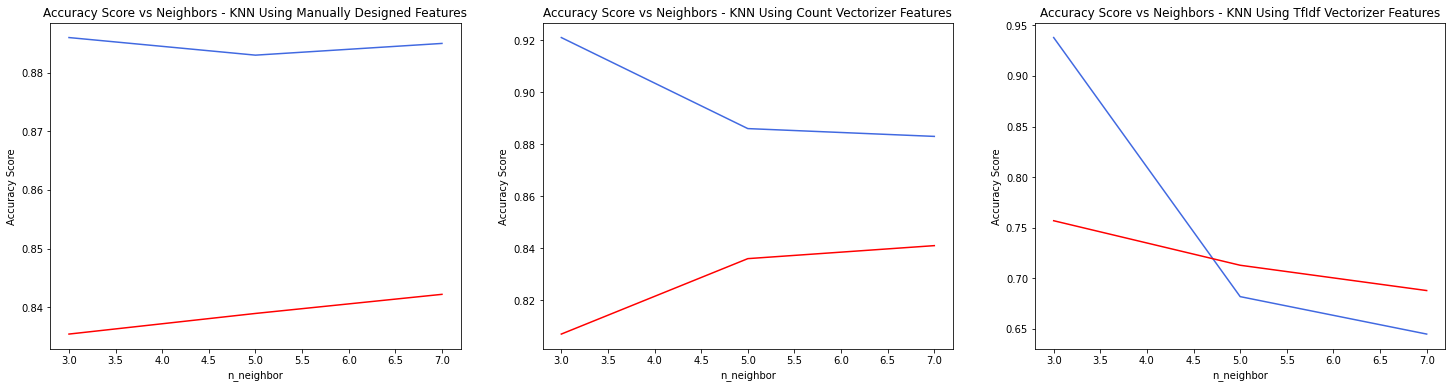

In [99]:
# Initialize Plot
plt.figure(figsize=(25,6))

# Plot Accuracies vs Regularization Strength for Logistic Regression using manually designed features
plt.subplot(131)
n_neighbor = knn_val_sum['Nearest Neighbors'][knn_val_sum['Input Feature Types'] == 'Manual']
mfd_train_acc = knn_val_sum['Training Accuracy'][knn_val_sum['Input Feature Types'] == 'Manual']
mfd_test_acc = knn_val_sum['Validation Accuracy'][knn_val_sum['Input Feature Types'] == 'Manual']
plt.plot(n_neighbor, mfd_train_acc, color='royalblue')
plt.plot(n_neighbor, mfd_test_acc, color='red')
plt.xlabel('n_neighbor')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs Neighbors - KNN Using Manually Designed Features')

# Plot Accuracies vs Regularization Strength for Logistic Regression using CountVectorizer features map
plt.subplot(132)
n_neighbor = knn_val_sum['Nearest Neighbors'][knn_val_sum['Input Feature Types'] == 'CountVect']
cv_train_acc = knn_val_sum['Training Accuracy'][knn_val_sum['Input Feature Types'] == 'CountVect']
cv_test_acc = knn_val_sum['Validation Accuracy'][knn_val_sum['Input Feature Types'] == 'CountVect']
plt.plot(n_neighbor, cv_train_acc, color='royalblue')
plt.plot(n_neighbor, cv_test_acc, color='red')
plt.xlabel('n_neighbor')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs Neighbors - KNN Using Count Vectorizer Features')

# Plot Accuracies vs Regularization Strength for Logistic Regression using Tfidf features map
plt.subplot(133)
n_neighbor = knn_val_sum['Nearest Neighbors'][knn_val_sum['Input Feature Types'] == 'TfIdf']
tfidf_train_acc = knn_val_sum['Training Accuracy'][knn_val_sum['Input Feature Types'] == 'TfIdf']
tfidf_test_acc = knn_val_sum['Validation Accuracy'][knn_val_sum['Input Feature Types'] == 'TfIdf']
plt.plot(n_neighbor, tfidf_train_acc, color='royalblue')
plt.plot(n_neighbor, tfidf_test_acc, color='red')
plt.xlabel('n_neighbor')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs Neighbors - KNN Using TfIdf Vectorizer Features')

plt.show()

#####Evaluate

,Input Feature Types,Nearest Neighbors,Training Accuracy,Testing Accuracy,F1-Score,AUC Score
0,Manual,5,0.881,0.839,0.870,0.923
1,CountVect,5,0.886,0.836,0.864,0.919
2,TfIdf,3,0.938,0.756,0.780,0.873


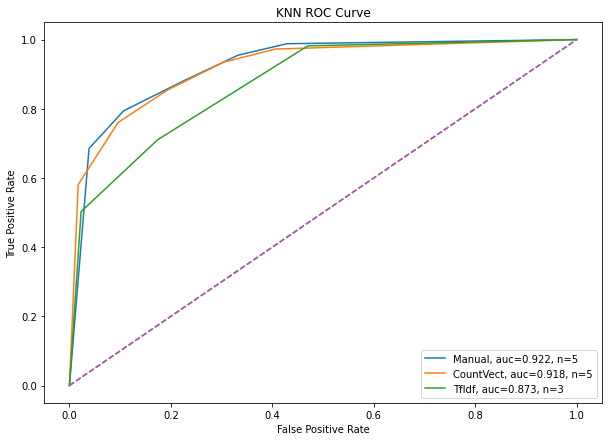

In [113]:
# Parameters Setup
metrics = ['Input Feature Types', 'Nearest Neighbors', 'Training Accuracy', 'Testing Accuracy', 'F1-Score', 'AUC Score']
modelname = 'KNN'
colors = ['blue', 'orange', 'red'] # indicates the corresponding color to represent in plot results

X_train_mfd, X_train_cv, X_train_tfidf = X_train[0], X_train[1], X_train[2]
X_test_mfd, X_test_cv, X_test_tfidf = X_test[0], X_test[1], X_test[2]

# Using num_neighbor=9 for KNN in Manually Designed Features
# knn_mfd = KNeighborsClassifier(n_neighbors = 9)
# knn_mfd_fit = knn_mfd.fit(X_train_mfd, y_train)
knn_mfd = pickle.load(open("model\KNN\KnnMod\.KNN0_5.pkl", 'rb'))
knn_mfd_trpred = knn_mfd.predict(X_train_mfd)
knn_mfd_tspred = knn_mfd.predict(X_test_mfd)
knn_mfd_tsprob = knn_mfd.predict_proba(X_test_mfd)
knn_mfd_tracc = accuracy_score(y_train, knn_mfd_trpred)
knn_mfd_tsacc = accuracy_score(y_test, knn_mfd_tspred)
knn_mfd_f1 = f1_score(y_test, knn_mfd_tspred)
knn_mfd_auc = roc_auc_score(y_test, knn_mfd_tsprob[:,1])
knn_mfd_fpr, knn_mfd_tpr, _ = roc_curve(y_test, knn_mfd_tsprob[:,1])

y_train = y_train_tkn
y_test = y_test_tkn
# Using num_neighbor=5 for KNN in CountVectorizer Features
# knn_cv = KNeighborsClassifier(n_neighbors = 5)
# knn_cv_fit = knn_cv.fit(X_train_cv, y_train)
knn_cv = pickle.load(open("model\KNN\KnnMod\.KNN1_5.pkl", 'rb'))
knn_cv_trpred = knn_cv.predict(X_train_cv)
knn_cv_tspred = knn_cv.predict(X_test_cv)
knn_cv_tsprob = knn_cv.predict_proba(X_test_cv)
knn_cv_tracc = accuracy_score(y_train, knn_cv_trpred)
knn_cv_tsacc = accuracy_score(y_test, knn_cv_tspred)
knn_cv_f1 = f1_score(y_test, knn_cv_tspred)
knn_cv_auc = roc_auc_score(y_test, knn_cv_tsprob[:,1])
knn_cv_fpr, knn_cv_tpr, _ = roc_curve(y_test, knn_cv_tsprob[:,1])
    
# Using num_neighbor=5 for KNN in TfIdf Vectorizer Features
# knn_tfidf = KNeighborsClassifier(n_neighbors = 3)
# knn_tfidf_fit = knn_tfidf.fit(X_train_tfidf, y_train)
knn_tfidf = pickle.load(open("model\KNN\KnnMod\.KNN2_3.pkl", 'rb'))
knn_tfidf_trpred = knn_tfidf.predict(X_train_tfidf)
knn_tfidf_tspred = knn_tfidf.predict(X_test_tfidf)
knn_tfidf_ttsprob = knn_tfidf.predict_proba(X_test_tfidf)
knn_tfidf_tracc = accuracy_score(y_train, knn_tfidf_trpred)
knn_tfidf_tsacc = accuracy_score(y_test, knn_tfidf_tspred)
knn_tfidf_f1 = f1_score(y_test, knn_tfidf_tspred)
knn_tfidf_auc = roc_auc_score(y_test, knn_tfidf_tsprob[:,1])
knn_tfidf_fpr, knn_tfidf_tpr, _ = roc_curve(y_test, knn_tfidf_tsprob[:,1])

knn_tracc = [knn_mfd_tracc, knn_cv_tracc, knn_tfidf_tracc]
knn_tsacc = [knn_mfd_tsacc, knn_cv_tsacc, knn_tfidf_tsacc]
knn_f1 = [knn_mfd_f1, knn_cv_f1, knn_tfidf_f1]
knn_auc = [knn_mfd_auc, knn_cv_auc, knn_tfidf_auc]
knn_neighbor = [5,5,3]
knn_labels = ['Manual', 'CountVect', 'TfIdf']
knn_fpr = [knn_mfd_fpr, knn_cv_fpr, knn_tfidf_fpr]
knn_tpr = [knn_mfd_tpr, knn_cv_tpr, knn_tfidf_tpr]

# Displaying final model evaluation
knn_sumarr = np.array([knn_labels, knn_neighbor, knn_tracc, knn_tsacc, knn_f1, knn_auc]).transpose()
knn_sum = pd.DataFrame(knn_sumarr, columns=metrics)
for i in metrics[2:]:
  knn_sum[i] = knn_sum[i].apply(lambda x: round(float(x),3))

# Save Test Dataset Evaluation to File
folderpath = 'model/trad_model/model_evaluation/'
filepath = folderpath + modelname + '.csv'
knn_sum.to_csv(filepath, index=False)
display(knn_sum)

# Plot of ROC Curve
plt.figure(figsize=(10,7))
for i in np.arange(len(X_labels)):
  plt.plot(knn_fpr[i],knn_tpr[i], label=knn_labels[i]+  ", auc="+str(knn_auc[i])[:5] + ", n=" + str(knn_neighbor[i]))
plt.plot([(0,0), (1,1)], linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(modelname + ' ROC Curve')
plt.legend()
plt.show()

#####Save ModeL

In [94]:
saveModel(knn_mfd, "KNN/KNN_Man_5")
saveModel(knn_cv, "KNN/KNN_CV_5") ##
saveModel(knn_tfidf, "KNN/KNN_TF3")

#####Others


#### Decision Tree


In [ ]:
#perform GridSearchCV
param_grid = {'criterion':['gini', 'entropy'], 'max_depth':np.arange(2,10), 'min_samples_split':np.arange(2,100)}
dt_model = DecisionTreeClassifier()
best_score, best_params = gridSearchCV(x_train, x_test, y_train, y_test, dt_model, param_grid, cv_value=5)
# Best Score:0.785700223914787
# Best Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 35}

Best Score:0.785700223914787
Best Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 35}


DecisionTreeClassifier
Train Accuracy Score: 0.7888044548090479
Test Accuracy Score: 0.7870192208222125

[[21852 15877]
 [ 4711 54226]]
              precision    recall  f1-score   support

           0       0.82      0.58      0.68     37729
           1       0.77      0.92      0.84     58937

    accuracy                           0.79     96666
   macro avg       0.80      0.75      0.76     96666
weighted avg       0.79      0.79      0.78     96666



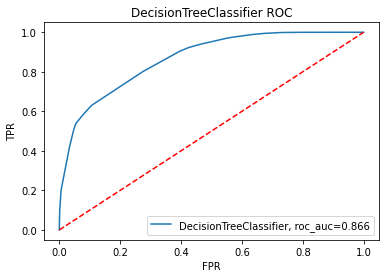

In [143]:
#Decision Tree 78,86
dt_model = DecisionTreeClassifier(min_samples_split=35, max_depth=9,criterion='entropy')
tr_predict, ts_predict, tr_accuracy, ts_accuracy = perfResult(x_train, x_val,  y_train, y_val, dt_model)
y_pred_prob, fpr_man, tpr_man, auc_man = plotROC(x_train, x_val,  y_train, y_val, dt_model)

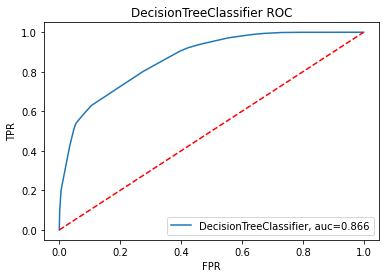

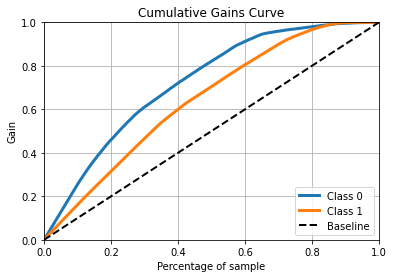

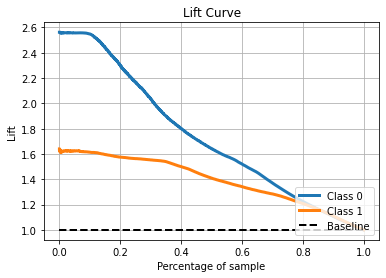

In [ ]:
plotROC_CummGain_Lift(x_train, x_val,  y_train, y_val, dt_model)

In [138]:
#perform GridSearchCV
param_grid = {'criterion':['gini', 'entropy'], 'max_depth':np.arange(2,10), 'min_samples_split':np.arange(2,100)}
dt_model_cv = DecisionTreeClassifier()
best_score, best_params = gridSearchCV(x_train_cv, x_val_cv, y_train_cv, y_val_cv, dt_model_cv, param_grid, cv_value=5)

DecisionTreeClassifier
Train Accuracy Score: 0.7868647862596096
Test Accuracy Score: 0.7843295471003249

[[23749 13980]
 [ 6868 52069]]
              precision    recall  f1-score   support

           0       0.78      0.63      0.69     37729
           1       0.79      0.88      0.83     58937

    accuracy                           0.78     96666
   macro avg       0.78      0.76      0.76     96666
weighted avg       0.78      0.78      0.78     96666



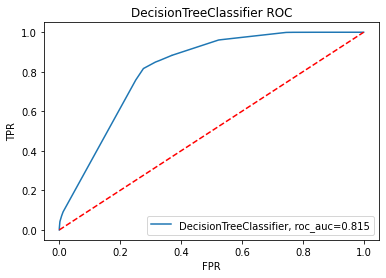

In [144]:
#Decision Tree #99,96
dt_model_cv = DecisionTreeClassifier(min_samples_split=35, max_depth=9,criterion='entropy')
# dt_model_cv = DecisionTreeClassifier()
tr_predict, ts_predict, tr_accuracy, ts_accuracy = perfResult(x_train_cv, x_val_cv, y_train_cv, y_val_cv,dt_model_cv)
y_pred_prob, fpr_cv, tpr_cv, auc_cv = plotROC(x_train_cv, x_val_cv, y_train_cv, y_val_cv, dt_model_cv)

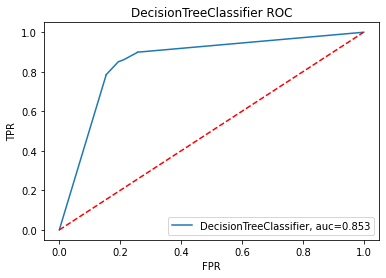

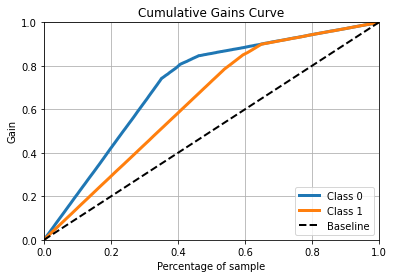

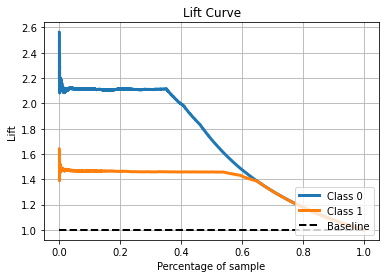

In [121]:
plotROC_CummGain_Lift(x_train_cv, x_val_cv, y_train_cv, y_val_cv, dt_model_cv)

DecisionTreeClassifier
Train Accuracy Score: 0.7929431533025351
Test Accuracy Score: 0.7903916578735026

[[23557 14172]
 [ 6090 52847]]
              precision    recall  f1-score   support

           0       0.79      0.62      0.70     37729
           1       0.79      0.90      0.84     58937

    accuracy                           0.79     96666
   macro avg       0.79      0.76      0.77     96666
weighted avg       0.79      0.79      0.78     96666



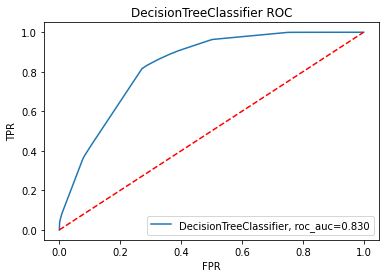

In [145]:
dt_model_tf = DecisionTreeClassifier(min_samples_split=50, max_depth=10,criterion='entropy')
tr_predict, ts_predict, tr_accuracy, ts_accuracy = perfResult(x_train_tf, x_val_tf, y_train_tf, y_val_tf,dt_model_tf)
y_pred_prob, fpr_tf, tpr_tf, auc_tf = plotROC(x_train_tf, x_val_tf, y_train_tf, y_val_tf,dt_model_tf)

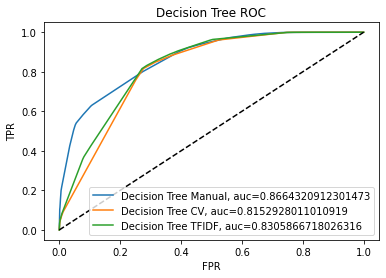

In [146]:
plt.title("Decision Tree" + " ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(fpr_man,tpr_man,label="Decision Tree Manual, auc="+str(auc_man))
plt.plot(fpr_cv,tpr_cv,label="Decision Tree CV, auc="+str(auc_cv))
plt.plot(fpr_tf,tpr_tf,label="Decision Tree TFIDF, auc="+str(auc_tf))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

In [142]:
saveModel(dt_model, "dt")
saveModel(dt_model_cv, "dt_cv")
saveModel(dt_model_tf, "dt_tf")

#### Random Forest

#####Training

In [152]:
# Parameters Setup
metrics = ['Input Feature Types', 'Number of Trees', 'Max Features Per Tree', 'Training Accuracy', 'Validation Accuracy', 'F1-Score', 'AUC Score']
n_trees = [3,5,10,25,50] # number of trees in RF to try out
n_features = [4,10,20,50] # number of features per tree to try out
modelname = 'RandomForest'

# Initialize
labels = []
tree = []
feature = []
tr_acc = []
tv_acc = []
F1 = []
auc = []
fpr = []
tpr = []

# Y_train=[y_train, y_train_tkn, y_train_tkn]
# Y_val=[y_val, y_val_tkn, y_train_tkn]
for i in range(len(X_labels)):
  for t in n_trees:
    for f in n_features:
      if f <= X_train[i].shape[1]:
        labels.append(X_labels[i])
        tree.append(t)
        feature.append(f)

        rf = RandomForestClassifier(n_estimators=t, max_features=f)
        rf_fit = rf.fit(X_train[i], Y_train[i])

        # Predictions
        rf_trpred = rf.predict(X_train[i])
        rf_tvpred = rf.predict(X_val[i])
        rf_tvprob = rf.predict_proba(X_val[i])

        # Accuracies  
        tr_acc.append(accuracy_score(Y_train[i], rf_trpred))
        tv_acc.append(accuracy_score(Y_val[i], rf_tvpred))
        
        # F1 Score
        F1.append(f1_score(y_val, rf_tvpred))

        # AUC Score
        auc.append(roc_auc_score(Y_val[i], rf_tvprob[:,1]))

        print(str(modelname) + str(X_labels[i]) + "_tree" + str(t) + 
              "_feature" + str(f), str(accuracy_score(Y_train[i], rf_trpred)), 
              str(accuracy_score(y_val, rf_tvpred)), 
              str(f1_score(Y_val[i], rf_tvpred)), 
              str(roc_auc_score(Y_val[i], rf_tvprob[:,1])))


# Training Evaluation Results
rf_val_sum = np.array([labels, tree, feature, tr_acc, tv_acc, F1, auc]).transpose()
rf_val_sum = pd.DataFrame(rf_val_sum, columns=metrics)
for i in metrics[3:]:
  rf_val_sum[i] = rf_val_sum[i].apply(lambda x: round(float(x),3))

# Save Training Evaluation Results
folderpath = 'model/trad_model/hyperparameter_tuning/'
filepath = folderpath + modelname + '.csv'
rf_val_sum.to_csv(filepath, index=False)

display(rf_val_sum)

,Input Feature Types,n_tree,n_features,Validation Acc,AUC Score
0,Manual,50,10,0.837895,0.932350
1,Manual,50,20,0.836954,0.932134
2,TfIdf,50,4,0.849000,0.932000
3,TfIdf,50,20,0.848000,0.932000
4,Manual,50,4,0.838402,0.931900
5,TfIdf,50,50,0.843000,0.931000
6,Manual,25,10,0.837730,0.930399
7,Manual,25,4,0.837554,0.929979
8,Manual,25,20,0.836654,0.929886
9,TfIdf,25,20,0.846709,0.929848


#####Evaluate

In [170]:
# Parameters Setup
metrics = ['Input Feature Types', 'Number of Trees', 'Max Features Per Tree', 'Training Accuracy', 'Testing Accuracy', 'F1-Score', 'AUC Score']
modelname = 'RandomForest'
colors = ['blue', 'orange', 'red'] # indicates the corresponding color to represent in plot results

X_train_mfd, X_train_cv, X_train_tfidf = X_train[0], X_train[1], X_train[2]
X_test_mfd, X_test_cv, X_test_tfidf = X_test[0], X_test[1], X_test[2]

# Using num_tree=50, max_feature=10 for RF in Manually Designed Features
rf_mfd = RandomForestClassifier(n_estimators=50, max_features=10)
rf_mfd_fit = rf_mfd.fit(X_train_mfd, y_train)
rf_mfd_trpred = rf_mfd.predict(X_train_mfd)
rf_mfd_tspred = rf_mfd.predict(X_test_mfd)
rf_mfd_tsprob = rf_mfd.predict_proba(X_test_mfd)
rf_mfd_tracc = accuracy_score(y_train, rf_mfd_trpred)
rf_mfd_tsacc = accuracy_score(y_test, rf_mfd_tspred)
rf_mfd_f1 = f1_score(y_test, rf_mfd_tspred)
rf_mfd_auc = roc_auc_score(y_test, rf_mfd_tsprob[:,1])
rf_mfd_fpr, rf_mfd_tpr, _ = roc_curve(y_test, rf_mfd_tsprob[:,1])


y_train = y_train_tkn
y_test = y_test_tkn

# Using num_tree=5, max_feature=10 for RF in CountVectorizer Features
rf_cv = RandomForestClassifier(n_estimators=10, max_features=20)
rf_cv_fit = rf_cv.fit(X_train_cv, y_train_tkn)
rf_cv_trpred = rf_cv.predict(X_train_cv)
rf_cv_tspred = rf_cv.predict(X_test_cv)
rf_cv_tsprob = rf_cv.predict_proba(X_test_cv)
rf_cv_tracc = accuracy_score(y_train_tkn, rf_cv_trpred)
rf_cv_tsacc = accuracy_score(y_test, rf_cv_tspred)
rf_cv_f1 = f1_score(y_test_tkn, rf_cv_tspred)
rf_cv_auc = roc_auc_score(y_test_tkn, rf_cv_tsprob[:,1])
rf_cv_fpr, rf_cv_tpr, _ = roc_curve(y_test_tkn, rf_cv_tsprob[:,1])

# Using num_tree=50, max_feature=4 for RF in TfIdf Vectorizer Features
rf_tfidf = RandomForestClassifier(n_estimators=50, max_features=4)
rf_tfidf_fit = rf_tfidf.fit(X_train_tfidf, y_train_tkn)
rf_tfidf_trpred = rf_tfidf.predict(X_train_tfidf)
rf_tfidf_tspred = rf_tfidf.predict(X_test_tfidf)
rf_tfidf_tsprob = rf_tfidf.predict_proba(X_test_tfidf)
rf_tfidf_tracc = accuracy_score(y_train_tkn, rf_tfidf_trpred)
rf_tfidf_tsacc = accuracy_score(y_test_tkn, rf_tfidf_tspred)
rf_tfidf_f1 = f1_score(y_test, rf_tfidf_tspred)
rf_tfidf_auc = roc_auc_score(y_test_tkn, rf_tfidf_tsprob[:,1])
rf_tfidf_fpr, rf_tfidf_tpr, _ = roc_curve(y_test_tkn, rf_tfidf_tsprob[:,1])

rf_tracc = [rf_mfd_tracc, rf_cv_tracc, rf_tfidf_tracc]
rf_tsacc = [rf_mfd_tsacc, rf_cv_tsacc, rf_tfidf_tsacc]
rf_f1 = [rf_mfd_f1, rf_cv_f1, rf_tfidf_f1]
rf_auc = [rf_mfd_auc, rf_cv_auc, rf_tfidf_auc]
rf_tree = [50, 5, 50]
rf_feature = [10, 10, 4]
rf_labels = ['Manual', 'CountVect', 'TfIdf']
rf_fpr = [rf_mfd_fpr, rf_cv_fpr, rf_tfidf_fpr]
rf_tpr = [rf_mfd_tpr, rf_cv_tpr, rf_tfidf_tpr]

# Displaying final model evaluation
rf_sumarr = np.array([rf_labels, rf_tree, rf_feature, rf_tracc, rf_tsacc, rf_f1, rf_auc]).transpose()
rf_sum = pd.DataFrame(rf_sumarr, columns=metrics)
for i in metrics[3:]:
  rf_sum[i] = rf_sum[i].apply(lambda x: round(float(x),3))

# Save Test Dataset Evaluation to File
folderpath = 'model/trad_model/model_evaluation/'
filepath = folderpath + modelname + '.csv'
rf_sum.to_csv(filepath, index=False)
display(rf_sum)

# Plot of ROC Curve
plt.figure(figsize=(10,7))
for i in np.arange(len(X_labels)):
  plt.plot(rf_fpr[i],rf_tpr[i], label=rf_labels[i]+  ", auc="+str(rf_auc[i])[:5] + ", r=" + str(rf_c[i]))
plt.plot([(0,0), (1,1)], linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(modelname + ' ROC Curve')
plt.legend()
plt.show()

,Input Feature Types,n_tree,n_features,Validation Accuracy,AUC Score
0,Manual,50,10,0.837895,0.932350
1,CountVect,5,10,0.844744,0.909507
2,TfIdf,50,4,0.849000,0.932000


#####Save

#####Others


RandomForestClassifier
Train Accuracy Score: 0.9175563279746757
Test Accuracy Score: 0.8355591877269388

[[29162  8568]
 [ 7328 51609]]
              precision    recall  f1-score   support

           0       0.80      0.77      0.79     37730
           1       0.86      0.88      0.87     58937

    accuracy                           0.84     96667
   macro avg       0.83      0.82      0.83     96667
weighted avg       0.83      0.84      0.84     96667



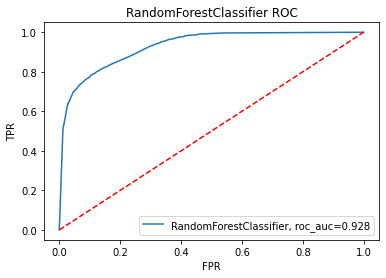

In [179]:
rfman = RandomForestClassifier(n_estimators=50, max_features=10)
tr_predict_man, ts_predict_man, tr_accuracy_man, ts_accuracy_man = perfResult(x_train, x_test,  y_train, y_test, rfman)
y_pred_prob_man, fpr_man, tpr_man, auc_man = plotROC(x_train, x_test,  y_train, y_test, rfman)

RandomForestClassifier
Train Accuracy Score: 0.9405308706562509
Test Accuracy Score: 0.8399557242906059

[[29271  8459]
 [ 7012 51925]]
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     37730
           1       0.86      0.88      0.87     58937

    accuracy                           0.84     96667
   macro avg       0.83      0.83      0.83     96667
weighted avg       0.84      0.84      0.84     96667



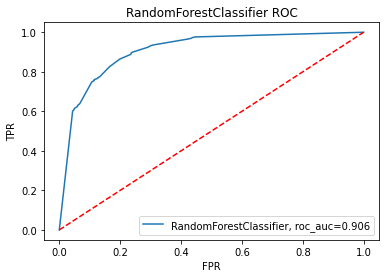

In [184]:
rfcv = RandomForestClassifier(n_estimators=5, max_features=10)
tr_predict_cv, ts_predict_cv, tr_accuracy_cv, ts_accuracy_cv = perfResult(x_train_cv, x_test_cv,  y_train_cv, y_test_cv, rfcv)
y_pred_prob_cv, fpr_cv, tpr_cv, auc_cv = plotROC(x_train_cv, x_test_cv,  y_train_cv, y_test_cv, rfcv)

RandomForestClassifier
Train Accuracy Score: 0.9452437110403717
Test Accuracy Score: 0.8457488077627319

[[29334  8396]
 [ 6515 52422]]
              precision    recall  f1-score   support

           0       0.82      0.78      0.80     37730
           1       0.86      0.89      0.88     58937

    accuracy                           0.85     96667
   macro avg       0.84      0.83      0.84     96667
weighted avg       0.84      0.85      0.84     96667



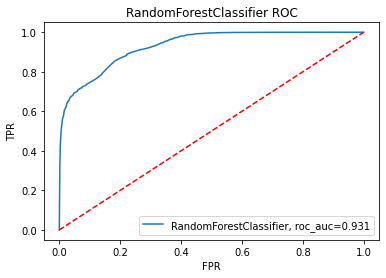

In [180]:
rfc2 = RandomForestClassifier(n_estimators=50, max_features=4)
tr_predict_tf, ts_predict_tf, tr_accuracy_tf, ts_accuracy_tf = perfResult(x_train_tf, x_test_tf, y_train_tf, y_test_tf, rftf)
y_pred_prob_tf, fpr_tf, tpr_tf, auc_tf = plotROC(x_train_tf, x_test_tf, y_train_tf, y_test_tf,rftf)

In [191]:
rfEv = pd.read_csv("model/__RF/RF_Eval.csv")
display(rfEv)
dfi.export(rfEv, 'model/__RF/RF_Eval.png')

,Input Feature Types,n_tree,n_features,Training Score,Testing Accuracy,F1-Score,AUC Score
0,Manual,50,10,0.917,0.836,0.87,0.929
1,CountVect,5,10,0.941,0.840,0.87,0.907
2,TfIdf,50,4,0.945,0.846,0.88,0.931


In [192]:
saveModel(rfman,"__RF/rfman")
saveModel(rfcv, "__RF/rfcv")
saveModel(rftf, "__RF/rftf")

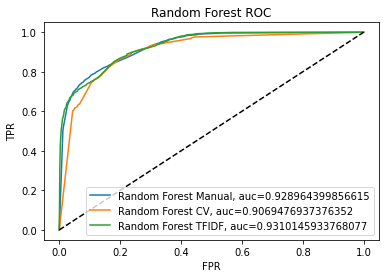

In [187]:
plt.title("Random Forest" + " ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(fpr_man,tpr_man,label="Random Forest Manual, auc="+str(auc_man))
plt.plot(fpr_cv,tpr_cv,label="Random Forest CV, auc="+str(auc_cv))
plt.plot(fpr_tf,tpr_tf,label="Random Forest TFIDF, auc="+str(auc_tf))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

#### Adaboost

#####Training

In [105]:
# Parameters Setup
metrics = ['Input Feature Types', 'Number of Trees', 'Max Features Per Tree', 'Training Accuracy', 'Validation Accuracy', 'F1-Score', 'AUC Score']
n_trees = [25, 50, 100] # number of trees in AdaBoost to try out
tree_depth = [1,2,4,10] # Depth of the weak learners (Decision Tree)
modelname = 'AdaBoost'

# Initialize
labels = []
tree = []
depth = []
tr_acc = []
tv_acc = []
F1 = []
auc = []
fpr = []
tpr = []

for i in range(len(X_labels)):
  for t in n_trees:
    for d in tree_depth:
      if d <= X_train[i].shape[1]:
        labels.append(X_labels[i])
        tree.append(t)
        depth.append(d)

        base = DecisionTreeClassifier(max_depth=d)
        ad = AdaBoostClassifier(n_estimators=t, base_estimator=base)
        ad_fit = ad.fit(X_train[i], y_train)

        # Predictions
        ad_trpred = ad.predict(X_train[i])
        ad_tvpred = ad.predict(X_val[i])
        ad_tvprob = ad.predict_proba(X_val[i])

        # Accuracies  
        tr_acc.append(accuracy_score(y_train, ad_trpred))
        tv_acc.append(accuracy_score(y_val, ad_tvpred))
        
        # F1 Score
        F1.append(f1_score(y_val, ad_tvpred))

        # AUC Score
        auc.append(roc_auc_score(y_val, ad_tvprob[:,1]))

# Training Evaluation Results
ad_val_sumarr = np.array([labels, tree, depth, tr_acc, tv_acc, F1, auc]).transpose()
ad_val_sum = pd.DataFrame(ad_val_sumarr, columns=metrics)
for i in metrics[3:]:
  ad_val_sum[i] = ad_val_sum[i].apply(lambda x: round(float(x),3))

# Save Training Evaluation Results
folderpath = 'model/trad_model/hyperparameter_tuning/'
filepath = folderpath + modelname + '.csv'
ad_val_sum.to_csv(filepath, index=False)

display(ad_val_sum)

,Input Feature Types,Number of Trees,Max Features Per Tree,Training Accuracy,Validation Accuracy,F1-Score,AUC Score
0,Manual,25,1,0.783,0.780,0.829,0.864
1,Manual,25,2,0.804,0.803,0.847,0.887
2,Manual,25,4,0.824,0.823,0.860,0.911
3,Manual,25,10,0.874,0.850,0.880,0.932
4,Manual,50,1,0.790,0.789,0.838,0.875
5,Manual,50,2,0.814,0.814,0.854,0.901
6,Manual,50,4,0.835,0.833,0.867,0.921
7,Manual,50,10,0.891,0.847,0.876,0.925
8,Manual,100,1,0.798,0.797,0.843,0.883
9,Manual,100,2,0.822,0.821,0.859,0.909


# Evaluate

,Input Feature Types,Number of Trees,Max Features Per Tree,Training Accuracy,Testing Accuracy,F1-Score,AUC Score
0,Manual,25,10,0.875,0.848,0.878,0.930
1,CountVect,100,10,0.874,0.861,0.888,0.945
2,TfIdf,100,10,0.878,0.856,0.884,0.936


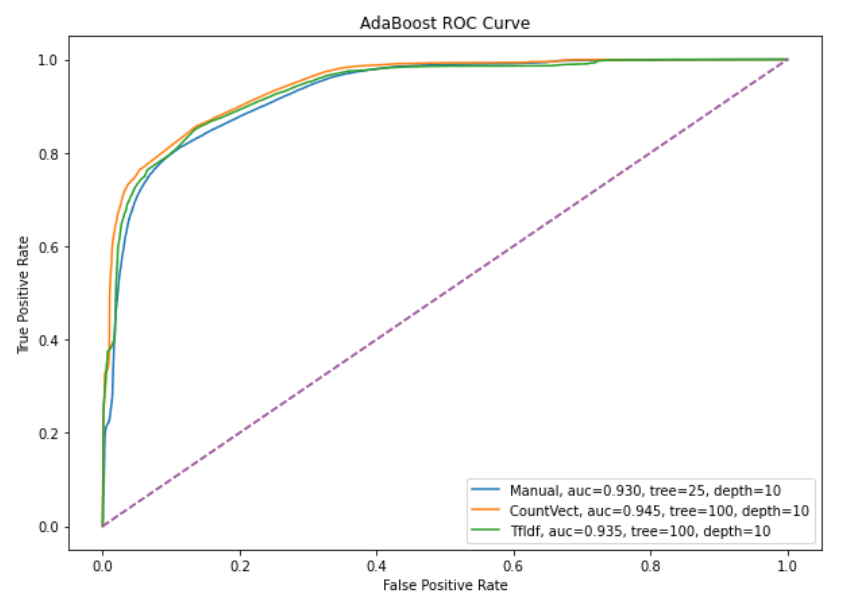

In [117]:
# Parameters Setup
metrics = ['Input Feature Types', 'Number of Trees', 'Max Features Per Tree', 'Training Accuracy', 'Testing Accuracy', 'F1-Score', 'AUC Score']
modelname = 'AdaBoost'
colors = ['blue', 'orange', 'red'] # indicates the corresponding color to represent in plot results

X_train_mfd, X_train_cv, X_train_tfidf = X_train[0], X_train[1], X_train[2]
X_test_mfd, X_test_cv, X_test_tfidf = X_test[0], X_test[1], X_test[2]

# Using num_trees=25, tree_depth=10 for AdaBoost in Manually Designed Features
base_mfd = DecisionTreeClassifier(max_depth=10)
ad_mfd = AdaBoostClassifier(n_estimators=25, base_estimator=base_mfd)
ad_mfd_fit = ad_mfd.fit(X_train_mfd, y_train)
ad_mfd_trpred = ad_mfd.predict(X_train_mfd)
ad_mfd_tspred = ad_mfd.predict(X_test_mfd)
ad_mfd_tsprob = ad_mfd.predict_proba(X_test_mfd)
ad_mfd_tracc = accuracy_score(y_train, ad_mfd_trpred)
ad_mfd_tsacc = accuracy_score(y_test, ad_mfd_tspred)
ad_mfd_f1 = f1_score(y_test, ad_mfd_tspred)
ad_mfd_auc = roc_auc_score(y_test, ad_mfd_tsprob[:,1])
ad_mfd_fpr, ad_mfd_tpr, _ = roc_curve(y_test, ad_mfd_tsprob[:,1])

y_train = y_train_tkn
y_test = y_test_tkn

# Using num_trees=100, tree_depth=10 for AdaBoost in CountVectorizer Features
base_cv = DecisionTreeClassifier(max_depth=10)
ad_cv = AdaBoostClassifier(n_estimators=100, base_estimator=base_cv)
ad_cv_fit = ad_cv.fit(X_train_cv, y_train)
ad_cv_trpred = ad_cv.predict(X_train_cv)
ad_cv_tspred = ad_cv.predict(X_test_cv)
ad_cv_tsprob = ad_cv.predict_proba(X_test_cv)
ad_cv_tracc = accuracy_score(y_train, ad_cv_trpred)
ad_cv_tsacc = accuracy_score(y_test, ad_cv_tspred)
ad_cv_f1 = f1_score(y_test, ad_cv_tspred)
ad_cv_auc = roc_auc_score(y_test, ad_cv_tsprob[:,1])
ad_cv_fpr, ad_cv_tpr, _ = roc_curve(y_test, ad_cv_tsprob[:,1])

# Using num_trees=100, tree_depth=10 for AdaBoost in TfIdf Vectorizer Features
base_tfidf = DecisionTreeClassifier(max_depth=10)
ad_tfidf = AdaBoostClassifier(n_estimators=100, base_estimator=base_tfidf)
ad_tfidf_fit = ad_tfidf.fit(X_train_tfidf, y_train)
ad_tfidf_trpred = ad_tfidf.predict(X_train_tfidf)
ad_tfidf_tspred = ad_tfidf.predict(X_test_tfidf)
ad_tfidf_tsprob = ad_tfidf.predict_proba(X_test_tfidf)
ad_tfidf_tracc = accuracy_score(y_train, ad_tfidf_trpred)
ad_tfidf_tsacc = accuracy_score(y_test, ad_tfidf_tspred)
ad_tfidf_f1 = f1_score(y_test, ad_tfidf_tspred)
ad_tfidf_auc = roc_auc_score(y_test, ad_tfidf_tsprob[:,1])
ad_tfidf_fpr, ad_tfidf_tpr, _ = roc_curve(y_test, ad_tfidf_tsprob[:,1])

ad_tracc = [ad_mfd_tracc, ad_cv_tracc, ad_tfidf_tracc]
ad_tsacc = [ad_mfd_tsacc, ad_cv_tsacc, ad_tfidf_tsacc]
ad_f1 = [ad_mfd_f1, ad_cv_f1, ad_tfidf_f1]
ad_auc = [ad_mfd_auc, ad_cv_auc, ad_tfidf_auc]
ad_tree = [25, 100, 100]
ad_depth = [10, 10, 10]
ad_labels = ['Manual', 'CountVect', 'TfIdf']
ad_fpr = [ad_mfd_fpr, ad_cv_fpr, ad_tfidf_fpr]
ad_tpr = [ad_mfd_tpr, ad_cv_tpr, ad_tfidf_tpr]

# Displaying final model evaluation
ad_sumarr = np.array([ad_labels, ad_tree, ad_depth, ad_tracc, ad_tsacc, ad_f1, ad_auc]).transpose()
ad_sum = pd.DataFrame(ad_sumarr, columns=metrics)
for i in metrics[3:]:
  ad_sum[i] = ad_sum[i].apply(lambda x: round(float(x),3))

# Save Test Dataset Evaluation to File
folderpath = 'model/trad_model/model_evaluation/'
filepath = folderpath + modelname + '.csv'
ad_sum.to_csv(filepath, index=False)
display(ad_sum)

# Plot of ROC Curve
plt.figure(figsize=(10,7))
for i in np.arange(len(X_labels)):
  plt.plot(ad_fpr[i],ad_tpr[i], label=ad_labels[i]+  ", auc="+str(ad_auc[i])[:5] + ", tree=" + str(ad_tree[i]) + ", depth=" + str(ad_depth[i]))
plt.plot([(0,0), (1,1)], linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(modelname + ' ROC Curve')
plt.legend()
plt.show()

#####Save

In [108]:
# saveModel(ad_mfd, "ad_mfd_85_93")
# saveModel(ad_cv, "ad_cv_86_94") ##
# saveModel(ad_tfidf, "ad_tfidf_85_93")

#####MLP

Iteration 1, loss = 0.48892194
Iteration 2, loss = 0.41243751
Iteration 3, loss = 0.39747053
Iteration 4, loss = 0.39028495
Iteration 5, loss = 0.38426639
Iteration 6, loss = 0.37971412
Iteration 7, loss = 0.37578643
Iteration 8, loss = 0.37248765
Iteration 9, loss = 0.37023495
Iteration 10, loss = 0.36780626
Iteration 11, loss = 0.36603401
Iteration 12, loss = 0.36464369
Iteration 13, loss = 0.36334600
Iteration 14, loss = 0.36204360
Iteration 15, loss = 0.36084161
Iteration 16, loss = 0.36008397
Iteration 17, loss = 0.35870950
Iteration 18, loss = 0.35826905
Iteration 19, loss = 0.35743676
Iteration 20, loss = 0.35680908
Iteration 21, loss = 0.35605000
Iteration 22, loss = 0.35557087
Iteration 23, loss = 0.35466302
Iteration 24, loss = 0.35413130
Iteration 25, loss = 0.35359516
Iteration 26, loss = 0.35335574
Iteration 27, loss = 0.35240662
Iteration 28, loss = 0.35218291
Iteration 29, loss = 0.35168420
Iteration 30, loss = 0.35154407
Iteration 31, loss = 0.35051213
Iteration 32, los

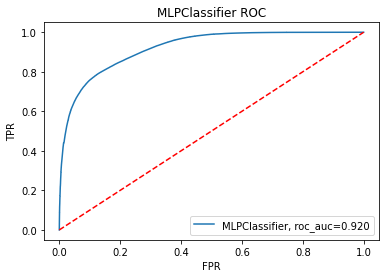

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10,10,20,20), max_iter=1000,verbose=0)  #0.83, 0.83, 0.92
tr_predict, ts_predict, tr_accuracy, ts_accuracy = perfResult(x_train_scale, x_val_scale, y_train, y_val,  mlp)
y_pred_prob, fpr, tpr, auc=plotROC(x_train_scale, x_val_scale, y_train, y_val, mlp)

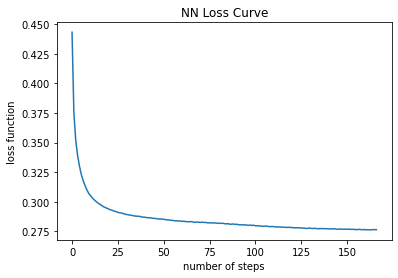

In [ ]:
plt.plot(mlp.loss_curve_)
plt.title("NN Loss Curve")
plt.xlabel("number of steps")
plt.ylabel("loss function")
plt.show()

#### NB

MultinomialNB
Train Accuracy Score: 0.9118038252480559
Test Accuracy Score: 0.8677611569734963

[[29540  8189]
 [ 4594 54343]]
              precision    recall  f1-score   support

           0       0.87      0.78      0.82     37729
           1       0.87      0.92      0.89     58937

    accuracy                           0.87     96666
   macro avg       0.87      0.85      0.86     96666
weighted avg       0.87      0.87      0.87     96666



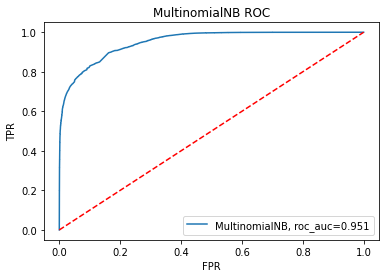

In [133]:
#NB
#NB - strong independence assumptions between the features. 
NB = MultinomialNB()
tr_predict_cv, ts_predict_cv, tr_accuracy_cv, ts_accuracy_cv = perfResult(x_train_cv, x_val_cv, y_train_cv, y_val_cv, NB)
y_pred_prob_cv, fpr_cv, tpr_cv, auc_cv = plotROC(x_train_cv, x_val_cv, y_train_cv, y_val_cv,NB)

MultinomialNB
Train Accuracy Score: 0.9193984589056279
Test Accuracy Score: 0.8659507996606873

[[28784  8945]
 [ 4013 54924]]
              precision    recall  f1-score   support

           0       0.88      0.76      0.82     37729
           1       0.86      0.93      0.89     58937

    accuracy                           0.87     96666
   macro avg       0.87      0.85      0.86     96666
weighted avg       0.87      0.87      0.86     96666



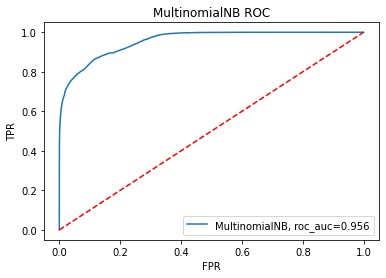

In [134]:
NB2 = MultinomialNB()
tr_predict_tf, ts_predict_tf, tr_accuracy_tf, ts_accuracy_tf = perfResult(x_train_tf, x_val_tf, y_train_tf, y_val_tf, NB2)
y_pred_prob_tf, fpr_tf, tpr_tf, auc_tf = plotROC(x_train_tf, x_val_tf, y_train_tf, y_val_tf,NB2)

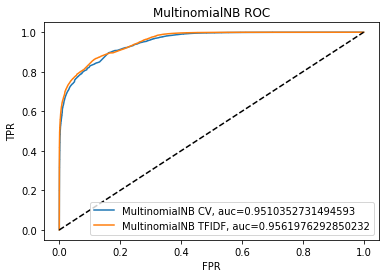

In [137]:
plt.title("MultinomialNB" + " ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(fpr_cv,tpr_cv,label="MultinomialNB CV, auc="+str(auc_cv))
plt.plot(fpr_tf,tpr_tf,label="MultinomialNB TFIDF, auc="+str(auc_tf))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

In [147]:
print(tr_accuracy_cv, ts_accuracy_cv)
print(tr_accuracy_tf, ts_accuracy_tf)

0.9118038252480559 0.8677611569734963
0.9193984589056279 0.8659507996606873


In [149]:
nb = pd.read_csv("model/NB/NB_Tr.csv")
display(nb)
dfi.export(nb, 'model/NB/NB_Tr.png')

,Input Feature Types,Alpha,Training Acc,Testing Acc,F1-Score,AUC Score
0,CountVectorizer,1,0.911804,0.867761,0.87,0.951
1,TfIdf,1,0.919398,0.865951,0.89,0.956


,ML-Features,Training Accuracy,Testing Accuracy,F1-Score,AUC Score
0,LogReg-CV,0.870000,0.896000,0.880,0.958
1,NB-TfIdf,0.919398,0.865951,0.890,0.956
2,NB-CV,0.911804,0.867761,0.870,0.951
3,AdaBoost-CV,0.874000,0.860000,0.887,0.944
4,LogReg-CV,0.855000,0.848000,0.878,0.936


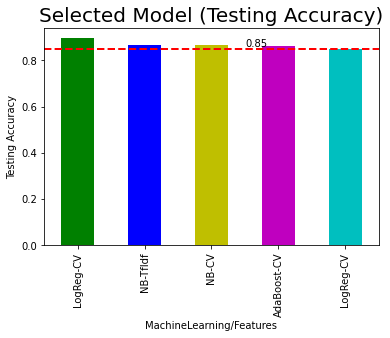

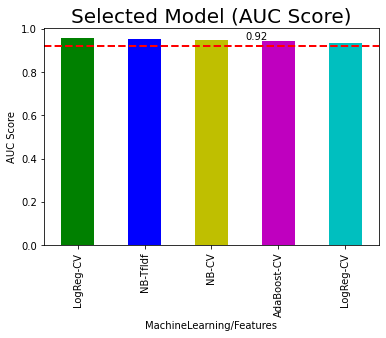

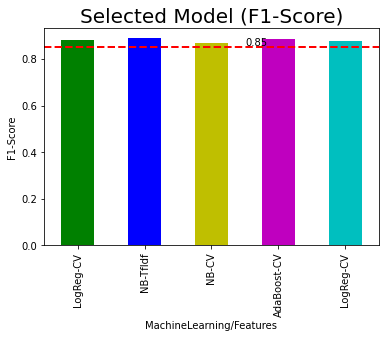

In [165]:
modcom = pd.read_csv("model/model_compare.csv")
display(modcom)

df = pd.Series(list(modcom["Testing Accuracy"]), index=list(modcom["ML-Features"]))
#Set descriptions:
plt.title("Selected Model (Testing Accuracy)", fontsize=20)
plt.ylabel('Testing Accuracy')
plt.xlabel('MachineLearning/Features')
#Set tick colors:
ax = plt.gca()
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
#Plot the data:
color = list('gbymc') #red, green, blue, black, etc.
df.plot(kind='bar',color=color)
plt.axhline(y=0.85, color='r', linestyle='--', linewidth=2)
plt.text(2.5,0.86,'0.85')
plt.show()

df = pd.Series(list(modcom["AUC Score"]), index=list(modcom["ML-Features"]))
#Set descriptions:
plt.title("Selected Model (AUC Score)", fontsize=20)
plt.ylabel('AUC Score')
plt.xlabel('MachineLearning/Features')
#Set tick colors:
ax = plt.gca()
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
#Plot the data:
color = list('gbymc') #red, green, blue, black, etc.
df.plot(kind='bar',color=color, align='center')
plt.axhline(y=0.92, color='r', linestyle='--', linewidth=2)
plt.text(2.5,0.95,'0.92')
plt.show()

df = pd.Series(list(modcom["F1-Score"]), index=list(modcom["ML-Features"]))
#Set descriptions:
plt.title("Selected Model (F1-Score)", fontsize=20)
plt.ylabel('F1-Score')
plt.xlabel('MachineLearning/Features')
#Set tick colors:
ax = plt.gca()
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
#Plot the data:
color = list('gbymc') #red, green, blue, black, etc.
df.plot(kind='bar',color=color, align='center')
plt.axhline(y=0.85, color='r', linestyle='--', linewidth=2)
plt.text(2.5,0.86,'0.85')
plt.show()